# Beeldherkenning

In dit Notebook wordt een model getrained om automatisch afbeeldingen te classificeren. Dit model heet een neuraal netwerk, een convolutional netwerk, AI, automatische beeldherkenning, en nog wat. Waar het op neer komt is dat het model patronen in afbeeldingen leert herkennen, die bij een bepaalde klasse (= class(ification), label, soort, type...) horen. Hiervoor is een gelabelde dataset nodig. Van elke klasse die het model moet leren herkennen, zijn er foto's nodig; hoe meer hoe beter. Als het model erin slaagt om de verschillende klasses uit elkaar te halen, dan zou het ook nieuwe foto's, zonder label, kunnen classificeren met de juiste label.

Voordat je met dit Notebook aan de slag gaat, moet de trainingsdata in deze structuur gezet worden:

```
├── Dataset
│   ├── Klasse A
│   ├── Klasse B
│   └── Klasse C
```

Als dit nog niet het geval is, kijk dan eerst naar het notebook `DataVoorbereiden.ipynb`.

## Setup

In [1]:
# Get pretty much everything that is needed for this Notebook
# !{sys.executable} -m pip install torchvision
# !{sys.executable} -m pip freeze  # List installed dependencies

In [2]:
# Inspired by https://www.youtube.com/watch?v=jF43_wj_DCQ&t=664s&ab_channel=PyTorch

In [3]:
# Imports

## General
import sys
import torch
import numpy as np
import time
from datetime import datetime

## Data
from pathlib import Path
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import find_classes
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from mothUtils import FilteredImageFolder, SquareYoloCrop
from PIL import Image
import torchvision.transforms.functional as TF

## Model
from torchvision.models import get_model
from torchinfo import summary

## Visualisation
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import ConfusionMatrixDisplay

## Evaluation
from sklearn.metrics import precision_score, recall_score, classification_report


## GPU check
Het trainen van een neuraal netwerk gaat het snelst op een GPU. Als de output van het volgende blok 'cuda:0' is, dan wordt een GPU gebruikt. Als het 'cpu' is, dan ofwel heeft de huidige computer geen (bruikbare) GPU, of er is iets verkeerd ingesteld.

In [4]:
torch.cuda.is_available()

True

In [5]:
# Check if GPU is available, else pick CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:0


In [6]:
sys.executable

'/home/farfalla/miniconda3/envs/ml/bin/python'

## Instellingen

Pas deze variabelen aan voor de situatie.

- seed: dit controleert de random state; dezelfde seed leidt tot reproduceerbare uitkomsten van het model. Kies een leuk getal of laat het staan zoals het is.
- data_path: pad naar de folder met de dataset. Zelfde als `data_path` in `DataVoorbereiden.ipynb`. Structuur van de folder moet als volgt zijn:
  ```
    ├── data_path
    │   ├── Klasse A
    │   ├── Klasse B
    │   └── Klasse C
  ```
- min_samples: minimaal aantal foto's per klasse. Als een klasse minder foto's heeft, dan wordt het op één hoop gegooid met andere kleine klasses onder de noemer 'Overig'.
- other_class_weight: hoe belangrijk de klasse 'Overig' is. Tussen 0 en 1, standaard 0.5.
- val_fraction: deel van de dataset die als validatie gebruikt moet worden. Tussen 0 en 1, standaard 0.1.
- test_fraction: deel van de dataset die als test gebruikt moet worden. Tussen 0 en 1, standaard 0.1.
- batch_size: aantal foto's die tegelijkertijd aan het model gevoerd worden tijdens een trainingsstap. Hoe hoger, hoe sneller het trainen gaat, maar hoe meer geheugen er gebruikt wordt. Als er een OOM (= out of memory) error is, verlaag batch_size. Tussen 1 en 256 (of hoger, maar dit is een goede maximum), standaard 64.
- num_workers: Pas dit aan om de trainingstijd te beïnvloeden. Optimale waarde hangt af van de opstelling van de computer. Minimaal 1, standaard 4.
- model_name: Naam van het architectuur/het model dat verder getrained gaat worden op de dataset. Pas dit aan als er een OOM error is wanneer het model ingeladen wordt. Keuze uit 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b7', of andere modellen van torchvision, standaard 'efficientnet_b1'.
- T_0: later.
- eta_min: minimale training rate. Standaard 1e-6.
- eta_max: maximale training rate. Standaard 0.012.
- weight_decay: Standaard 1e-6.
- gamma: Standaard 0.99998.
- note: Een tekst die wordt opgeslagen in TensorBoard. Handig om later terug te vinden wat er speciaal was aan een run. Bijvoorbeeld, beschrijf welke parameters veranderd zijn t.o.v. de vorige run. 

In [7]:
# Variables to customise
seed = 1234
data_path = '/data/croppedDatasetNoPseudo'
min_samples = 1
other_class_weight = 0.5
val_fraction = 0.1
test_fraction = 0.1
train_fraction = 1 - (val_fraction+test_fraction)
batch_size = 128
num_workers = 8
model_name = 'efficientnet_b1'
T_0 = 2
eta_min = 1e-6
eta_max = 0.012
weight_decay = 1e-6
gamma = 0.99998
note = 'Test set on best model (and save paths)'


In [8]:
hparam_dict = dict(
    seed = seed,
    data_path = data_path,
    min_samples = min_samples,
    other_class_weight = other_class_weight,
    val_fraction = val_fraction,
    test_fraction = test_fraction,
    train_fraction = train_fraction,
    batch_size = batch_size,
    num_workers = num_workers,
    model_name = model_name,
    T_0 = T_0,
    eta_min = eta_min,
    eta_max = eta_max,
    weight_decay = weight_decay,
    gamma = gamma,
    note = note
)

In [9]:
image_sizes = {'efficientnet_b0': 224, 'efficientnet_b1': 240, 'efficientnet_b7': 600}

In [10]:
# Set the seed
torch.manual_seed(seed)


## Load the data

In [11]:
# Find which classes that have too few samples (n_samples < min_samples)
class_counts = {p.name: len(list(p.iterdir())) for p in Path(data_path).iterdir()}
classes = set(class_counts.keys())
classes_to_trim = {c for c, n in class_counts.items() if n < min_samples}
print(
    f"Found {len(classes)} classes. {len(classes_to_trim)} have less than {min_samples} samples.\n"
    f"{len(classes) - len(classes_to_trim)} have => {min_samples} samples."
)


Found 2512 classes. 0 have less than 1 samples.
2512 have => 1 samples.


In [12]:
for name in class_counts:
    if class_counts[name] == 0:
        print(name)

**Original:**

Found 1936 classes. 1108 have less than 50 samples.
828 have => 50 samples.

**English combined:**

Found 1878 classes. 1051 have less than 50 samples.
827 have => 50 samples.

**No pseudospecies, genus- and subspecies level classes:**

Found 1839 classes. 1021 have less than 50 samples.
818 have => 50 samples.

**Micros:**

Found 2513 classes. 1020 have less than 50 samples.
1493 have => 50 samples.

**Cleaned up classes:**

Found 2417 classes. 946 have less than 50 samples.
1471 have => 50 samples.

**Lower number of pictures per class:**

Found 2417 classes. 734 have less than 30 samples.
1683 have => 30 samples.

**New data:**

Found 2421 classes. 679 have less than 30 samples.
1742 have => 30 samples.

**No pseudospecies and no min_samples:**

Found 2512 classes. 0 have less than 1 samples.
2512 have => 1 samples.


In [13]:
## Define the data transformations
train_transform = transforms.Compose([
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.03),
    transforms.ToTensor(),
    transforms.Normalize((136.24, 133.32, 116.16), (46.18, 46.70, 48.89)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((136.24, 133.32, 116.16), (46.18, 46.70, 48.89)),
])

try:
    train_image_folder = FilteredImageFolder(data_path,
        transform=train_transform,
        classes_to_trim=classes_to_trim)
    test_image_folder = FilteredImageFolder(data_path,
        transform=test_transform,
        classes_to_trim=classes_to_trim)
except NameError:
    train_image_folder = ImageFolder(data_path,
        transform=train_transform)
    test_image_folder = ImageFolder(data_path,
        transform=test_transform)


In [14]:
class_mapping = train_image_folder.class_to_idx
print(f'{len(class_mapping)} classes loaded')


2512 classes loaded


In [15]:
if len(classes_to_trim) > 0:
    idx_to_class = {0: 'other'}
else:
    idx_to_class = {}

for key in class_mapping.keys():
    value = class_mapping[key]
    if len(classes_to_trim) == 0 or value > 0:
        idx_to_class[value] = key

print(f'The first class = {idx_to_class[0]}')


The first class = abraxas grossulariata


In [16]:
generator1 = torch.Generator().manual_seed(seed)
generator2 = torch.Generator().manual_seed(seed)

train_data, _, _ = random_split(
    train_image_folder,
    [train_fraction, val_fraction, test_fraction],
    generator1
)

_, val_data, test_data = random_split(
    test_image_folder,
    [train_fraction, val_fraction, test_fraction],
    generator2
)

In [17]:
train_data_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_data_loader = DataLoader(val_data,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=True,
                            pin_memory=True)
test_data_loader = DataLoader(test_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cidaria fulvata  teleiodes luculella  macaria alternata  archips xylosteana  apamea sordens  cydia pomonella  schoenobius gigantella  apotomis betuletana  ligdia adustata  crambus pratella  noctua pronuba  gracillaria syringella  lathronympha strigana  idaea dimidiata  conistra rubiginea  conistra vaccinii  hoplodrina octogenaria  chrysoteuchia culmella  nephopterix angustella  acleris variegana  grapholita discretana  tyria jacobaeae  eilema griseola  ptilodon capucina  lomographa bimaculata  leucania obsoleta  xestia xanthographa  conistra erythrocephala  spilosoma lubricipeda  olethreutes arcuella  eupithecia virgaureata  emmelina monodactyla  pterostoma palpina  cacoecimorpha pronubana  orthosia gothica  furcula furcula  pelurga comitata  anania funebris  pterophorus pentadactyla  hemaris fuciformis  abraxas sylvata  hypsopygia glaucinalis  pyrrhia umbra  trichoplusia ni  opogona omoscopa  eupithecia tantillaria  hofmannophila pseudospretella  diarsia rubi  prolita sexpunctella  ag

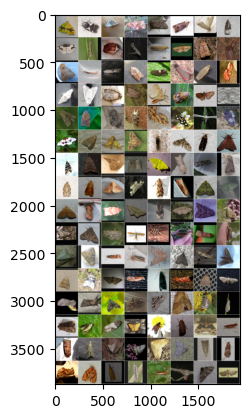

In [18]:
# Sanity check
nr_of_images = batch_size

def matplotlib_imshow(img):   
    invTrans = transforms.Compose([
        transforms.Normalize((0.0, 0.0, 0.0), (1/46.18, 1/46.70, 1/48.89)),
        transforms.Normalize((-136.24, -133.32, -116.16), (1.0, 1.0, 1.0))
    ])
    img = invTrans(img)  # un-normalise
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_data_loader)
images, labels = next(dataiter)
images = images[:nr_of_images]
labels = labels[:nr_of_images]
img_grid = make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(
    list(class_mapping.keys())[list(class_mapping.values())
                               .index(labels[j])] if labels[j] > 0 or len(classes_to_trim) == 0 else 'Onbekend' for j in range(nr_of_images)))
plt.show()


## Define the model

In [19]:
# Load the model
model = get_model(model_name, weights='DEFAULT')

In [20]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [21]:
# Replace the last layer with a new one
nr_in = model.classifier[1].in_features
nr_out = len(set(class_mapping.values()))
model.classifier[1] = torch.nn.Linear(nr_in, nr_out)

In [22]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2512, bias=True)
)

In [23]:
# Move model to GPU
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [24]:
summary(model, (batch_size, 3, image_sizes[model_name], image_sizes[model_name]))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [128, 2512]               --
├─Sequential: 1-1                                       [128, 1280, 8, 8]         --
│    └─Conv2dNormActivation: 2-1                        [128, 32, 120, 120]       --
│    │    └─Conv2d: 3-1                                 [128, 32, 120, 120]       864
│    │    └─BatchNorm2d: 3-2                            [128, 32, 120, 120]       64
│    │    └─SiLU: 3-3                                   [128, 32, 120, 120]       --
│    └─Sequential: 2-2                                  [128, 16, 120, 120]       --
│    │    └─MBConv: 3-4                                 [128, 16, 120, 120]       1,448
│    │    └─MBConv: 3-5                                 [128, 16, 120, 120]       612
│    └─Sequential: 2-3                                  [128, 24, 60, 60]         --
│    │    └─MBConv: 3-6                                

In [25]:
# Loss function
class_weights = torch.ones(nr_out)
if len(classes_to_trim) > 0:
    class_weights[0] = other_class_weight
print(class_weights[0])
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.004)

tensor(1.)


In [26]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=eta_max, weight_decay=weight_decay)  # 0.003

In [27]:
# Scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0, eta_min=eta_min)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                              eta_min,
                                              eta_max,
                                              step_size_up=1,
                                              step_size_down=len(train_data_loader)-1,
                                              mode='exp_range',
                                              gamma=gamma,
                                              cycle_momentum=False
                                            )

## Functions

In [28]:
def dict2mdtable(d, key='Name', val='Value'):
    rows = [f'| {key} | {val} |']
    rows += ['|--|--|']
    rows += [f'| {k} | {v} |' for k, v in d.items()]
    return "  \n".join(rows)

def dict2mdtablereport(d):
    rows = [f'| Label | Precision | Recall | F1 | Support |']
    rows += ['|--|--|--|--|--|']
    for k, v in d.items():
        try:
            rows += [f"| {k} | {v['precision']} | {v['recall']} | {v['f1-score']} | {v['support']} |"]
        except Exception as e:
            rows += [f"| {k} | {v} |  |  |  |"]
    return "\n".join(rows)

In [29]:
def validate(data_loader=None, return_results=False):
    running_loss = 0.
    outputs_array = []
    labels_array = []
    
    if data_loader == None:
        data_loader = val_data_loader

    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs_gpu = inputs.to(device, non_blocking=True)
        labels_gpu = labels.to(device, non_blocking=True)
        outputs_gpu = model(inputs_gpu).detach()
        loss = loss_fn(outputs_gpu, labels_gpu)
        running_loss += loss.detach()
        outputs_array.extend(torch.argmax(outputs_gpu, dim=1).tolist())
        labels_array.extend(labels_gpu.tolist())
        
    avg_loss = running_loss / (i+1)
    precision = precision_score(labels_array, outputs_array, average='weighted', zero_division=0.0)
    recall = recall_score(labels_array, outputs_array, average='weighted', zero_division=0.0)

    if return_results:
        return avg_loss, precision, recall, outputs_array, labels_array
    else:
        return avg_loss, precision, recall

In [30]:
# Training
def train_one_epoch(epoch_index, tb_writer, run_validate=True):
    running_loss = 0.
    last_loss = 0.
    t0 = time.time()
    iters = len(train_data_loader)
    
    for i, data in enumerate(train_data_loader):
        print('\r', 'Batch', i, 'out of', iters, end='')
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()
        # scheduler.step(epoch_index + i / iters)  # For CosineAnnealingWarmRestarts
        scheduler.step()
        
        running_loss += loss.detach().item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            # print(f'\n  batch {i + 1} loss: {last_loss} seconds: {time.time() - t0}')
            tb_x = epoch_index*len(train_data_loader) + i + 1
            if not run_validate:
                tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
            # Run validation set:
            if run_validate:
                model.train(False)
                avg_vloss, precision, recall = validate()
                model.train(True)
                print(f'valid loss: {avg_vloss} precision: {precision} recall: {recall}')
                writer.add_scalars('Precision vs. Recall (train)',
                                   {'Precision': precision, 'Recall': recall},
                                   tb_x)
                writer.add_scalars('Training vs. Validation Loss (train)',
                                   {'Training': last_loss, 'Validation': avg_vloss},
                                   tb_x)
            t0 = time.time()
    print('\n')
    return last_loss


## Training

In [31]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/{model_name}/moths_trainer_{timestamp}')
writer.add_text('Hyperparams', dict2mdtable(hparam_dict), 1)
epoch_number = 0


In [ ]:
EPOCHS = 30

# Declase best_vloss only when starting a new run
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}')
    
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, run_validate=False)

    model.train(False)
    avg_vloss, precision, recall = validate()
    print(f'LOSS train {avg_loss} valid {avg_vloss} (precision: {precision} recall: {recall})')
    writer.add_scalars('Precision vs. Recall',
                       {'Precision': precision, 'Recall': recall},
                       epoch_number + 1)
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()
    
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1


EPOCH 1
 Batch 142 out of 6493

## Testing

### If needed: load model

In [31]:
model = get_model(model_name, weights='DEFAULT')
model.classifier[1] = torch.nn.Linear(nr_in, nr_out)
model.to(device)
model_path = 'model_20231109_134031_19' # Best all species out of 8: model_20231109_134031_19
model.load_state_dict(torch.load(model_path))
model.train(False)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Run test
Write the overall test scores to TensorBoard.

In [33]:
model.train(False)
test_loss, test_precision, test_recall, y_pred, y_true = validate(test_data_loader, True)
print(f'Test scores: loss {test_loss} (precision: {test_precision} recall: {test_recall})')
writer.add_scalars('Precision vs. Recall (test)',
                   {'Precision': test_precision, 'Recall': test_recall},
                   1)
writer.add_scalars('Test Loss',
                   {'Test': test_loss},
                   1)
writer.flush()

Test scores: loss 0.545075535774231 (precision: 0.9038555840942291 recall: 0.9047146449803918)


### Classification report
Calculate a classification report with the scores per class, and write this to TensorBoard.

In [34]:
labels = []
target_names = []
for label in range(nr_out):
    labels.append(label)
    if label == 0 and len(classes_to_trim) > 0:
        target_name = 'Other'
    else:
        target_name = [i for i in class_mapping if class_mapping[i]==label][0]
    target_names.append(target_name)


In [27]:
with open('classMapping231106.pickle', 'wb') as f:
    pickle.dump(idx_to_class, f)
# idx_to_class[1222]

In [35]:
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names, zero_division=0.0))
report_dict = classification_report(y_true, y_pred, labels=labels, target_names=target_names, zero_division=0.0, output_dict=True)
writer.add_text('Test scores', dict2mdtablereport(report_dict), 1)


                                 precision    recall  f1-score   support

          abraxas grossulariata       0.89      0.89      0.89        96
                abraxas sylvata       0.97      0.93      0.95       121
           abrostola tripartita       0.92      0.89      0.90        79
            abrostola triplasia       0.90      0.94      0.92       266
             acanthopsyche atra       0.00      0.00      0.00         1
                acasis viretata       0.96      0.97      0.97        78
           acentria ephemerella       0.92      0.97      0.94       163
             acherontia atropos       0.87      0.87      0.87        75
             achlya flavicornis       0.97      0.93      0.95       108
               achroia grisella       0.83      0.88      0.85        43
               acleris abietana       0.86      0.80      0.83        15
              acleris aspersana       0.86      0.71      0.77        17
           acleris bergmanniana       1.00      0.

### Test pseudospecies

In [58]:
model.train(False)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [37]:
pseudospecies = ['noctua janthe-janthina',
                'acronicta psi-tridens',
                'mesapamea secalella-secalis',
                'thera britannica-variata',
                'xanthorhoe ferrugata-spadicearia',
                'epirrita christyi-dilutata-autumnata',
                'oligia latruncula-strigilis-versicolor',
                'amphipyra berbera-pyramidea',
                'aplocera efformata-plagiata',
                'cucullia scrophulariae-verbasci',
                'amphipoea fucosa-lucens-oculea',
                'chamaesphecia empiformis-tenthrediniformis',
                'scotopteryx luridata-mucronata',
                'acleris ferrugana-notana',
                'catoptria osthelderi-permutatellus',
                'yponomeuta spec',
                'agonopterix ciliella-heracliana',
                'cnephasia spec',
                'bactra lacteana-lancealana',
                'rhyacionia buoliana-pinicolana',
                'parornix spec',
                'phalonidia manniana-udana',
                'coleophora spec',
                'caloptilia betulicola-elongella',
                'dichrorampha spec'
]

no_pseudospecies = ['noctua janthe',
                    'noctua janthina',
                    'acronicta psi',
                    'acronicta tridens',
                    'mesapamea secalella',
                    'mesapamea secalis',
                    'thera britannica',
                    'thera variata',
                    'xanthorhoe spadicearia',
                    'epirrita christyi',
                    'epirrita dilutata',
                    'epirrita autumnata',
                    'oligia latruncula',
                    'oligia strigilis',
                    'oligia versicolor',
                    'amphipyra berbera',
                    'amphipyra pyramidea',
                    'aplocera efformata',
                    'aplocera plagiata',
                    'cucullia scrophulariae',
                    'cucullia verbasci',
                    'amphipoea fucosa',
                    'amphipoea lucens',
                    'amphipoea oculea',
                    'chamaesphecia empiformis',
                    'chamaesphecia tenthrediniformis',
                    'scotopteryx luridata',
                    'scotopteryx mucronata',
                    'acleris ferrugana',
                    'acleris notana',
                    'catoptria osthelderi',
                    'catoptria permutatellus',
                    'yponomeuta cagnagella',
                    'yponomeuta evonymella',
                    'yponomeuta malinellus',
                    'yponomeuta padella',
                    'yponomeuta rorrella',
                    'agonopterix ciliella',
                    'agonopterix heracliana',
                    'cnephasia incertana',
                    'cnephasia stephensiana',
                    'cnephasia asseclana',
                    'cnephasia communana',
                    'cnephasia genitalana',
                    'cnephasia pasiuana',
                    'cnephasia pumicana',
                    'cnephasia sedana',
                    'bactra lacteana',
                    'bactra lancealana',
                    'rhyacionia buoliana',
                    'rhyacionia pinicolana',
                    'parornix finitimella',
                    'parornix torquillella',
                    'parornix anglicella',
                    'parornix betulae',
                    'parornix carpinella',
                    'parornix devoniella',
                    'parornix fagivora',
                    'parornix scoticella',
                    'phalonidia manniana',
                    'phalonidia udana',
                    'coleophora lutipennella',
                    'coleophora flavipennella',
                    'coleophora badiipennella',
                    'coleophora limosipennella',
                    'coleophora adjunctella',
                    'coleophora adspersella',
                    'coleophora ahenella',
                    'coleophora albicans',
                    'coleophora albicosta',
                    'coleophora alnifoliae',
                    'coleophora alticolella',
                    'coleophora argentula',
                    'coleophora artemisicolella',
                    'coleophora asteris',
                    'coleophora atriplicis',
                    'coleophora binderella',
                    'coleophora boreella',
                    'coleophora bornicensis',
                    'coleophora caespititiella',
                    'coleophora calycotomella',
                    'coleophora conyzae',
                    'coleophora cornutella',
                    'coleophora deviella',
                    'coleophora discordella',
                    'coleophora follicularis',
                    'coleophora fuscocuprella',
                    'coleophora galbulipennella',
                    'coleophora genistae',
                    'coleophora glaucicolella',
                    'coleophora gryphipennella',
                    'coleophora hydrolapathella',
                    'coleophora juncicolella',
                    'coleophora lusciniaepennella ',
                    'coleophora maritimella ',
                    'coleophora milvipennis',
                    'coleophora ochripennella',
                    'coleophora orbitella',
                    'coleophora pennella',
                    'coleophora peribenanderi',
                    'coleophora potentillae',
                    'coleophora prunifoliae',
                    'coleophora salinella',
                    'coleophora saponariella',
                    'coleophora saturatella',
                    'coleophora saxicolella',
                    'coleophora serratella',
                    'coleophora siccifolia',
                    'coleophora solitariella',
                    'coleophora spinella',
                    'coleophora sternipennella',
                    'coleophora striatipennella',
                    'coleophora taeniipennella',
                    'coleophora tamesis',
                    'coleophora tanaceti',
                    'coleophora trochilella',
                    'coleophora vacciniella',
                    'coleophora vestianella',
                    'coleophora violacea',
                    'coleophora vitisella',
                    'caloptilia betulicola',
                    'caloptilia elongella',
                    'dichrorampha aeratana',
                    'dichrorampha sedatana',
                    'dichrorampha acuminatana',
                    'dichrorampha plumbana',
                    'dichrorampha plumbagana',
                    'dichrorampha simpliciana'
]

In [40]:
filter_species = False  # False = get results for all species

idxes = set()
print('label, labelId, path, prediction, predId, score')
for i in test_data.indices:
    idx = test_image_folder.targets[i]
    label = idx_to_class[idx]
    if !filter_species or label in no_pseudospecies:
        path = test_image_folder.samples[i][0]
        img = test_image_folder[i][0].to(device)
        img = img.unsqueeze_(0)
        output = model(img)
        output = output.data.cpu().numpy()
        pred_idx = output.argmax()
        prediction = idx_to_class[pred_idx]
        score = softmax(output[0]).max()
        print(f'{label}, {idx}, {path}, {prediction}, {pred_idx}, {score}')



label, labelId, path, prediction, predId, score
chamaesphecia tenthrediniformis, 534, /data/croppedDatasetNoPseudo/chamaesphecia tenthrediniformis/0194863.jpg, chamaesphecia tenthrediniformis, 534, 0.9677403569221497
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0181998.jpg, amphipyra pyramidea, 179, 0.9928786754608154
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0019209.jpg, hypsopygia glaucinalis, 1420, 0.09594128280878067
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0253696.jpg, thaumetopoea processionea, 2373, 0.06721033900976181
coleophora siccifolia, 692, /data/croppedDatasetNoPseudo/coleophora siccifolia/0625951.jpg, coleophora prunifoliae, 684, 0.13644595444202423
cnephasia genitalana, 591, /data/croppedDatasetNoPseudo/cnephasia genitalana/0625405.jpg, cnephasia stephensiana, 597, 0.335216224193573
xanthorhoe spadicearia, 2458, /data/croppedDatasetNoPseudo/xanthorhoe spadicearia/0334240.jpg, c

yponomeuta padella, 2478, /data/croppedDatasetNoPseudo/yponomeuta padella/0677551.jpg, yponomeuta padella, 2478, 0.9964949488639832
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186466.jpg, oligia strigilis, 1760, 0.9998898506164551
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0182036.jpg, amphipyra pyramidea, 179, 0.997210681438446
aplocera plagiata, 258, /data/croppedDatasetNoPseudo/aplocera plagiata/0470815.jpg, aplocera efformata, 257, 0.8046857714653015
parornix finitimella, 1863, /data/croppedDatasetNoPseudo/parornix finitimella/0798860.jpg, parornix betulae, 1859, 0.6067237257957458
acronicta psi, 63, /data/croppedDatasetNoPseudo/acronicta psi/0482639.jpg, acronicta psi, 63, 0.4858832061290741
dichrorampha acuminatana, 871, /data/croppedDatasetNoPseudo/dichrorampha acuminatana/0747712.jpg, dichrorampha acuminatana, 871, 0.9995568990707397
dichrorampha acuminatana, 871, /data/croppedDatasetNoPseudo/dichrorampha acuminatana/08

cnephasia stephensiana, 597, /data/croppedDatasetNoPseudo/cnephasia stephensiana/0680002.jpg, cnephasia stephensiana, 597, 0.9817551970481873
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0461082.jpg, noctua janthe, 1707, 0.9866011142730713
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0181745.jpg, amphipyra pyramidea, 179, 0.9125978350639343
coleophora discordella, 645, /data/croppedDatasetNoPseudo/coleophora discordella/0107859.jpg, crambus pascuella, 752, 0.1851348876953125
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0089948.jpg, autographa gamma, 356, 0.12669019401073456
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0090031.jpg, noctua janthe, 1707, 0.9339889287948608
acleris notana, 28, /data/croppedDatasetNoPseudo/acleris notana/0715474.jpg, acleris notana, 28, 0.9565726518630981
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0729838.jpg, yponomeuta evonymella, 24

coleophora flavipennella, 647, /data/croppedDatasetNoPseudo/coleophora flavipennella/0935070.jpg, crambus perlella, 753, 0.8242213129997253
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0106312.jpg, bactra lancealana, 363, 0.9725643992424011
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518594.jpg, epirrita dilutata, 1099, 0.9948287606239319
aplocera plagiata, 258, /data/croppedDatasetNoPseudo/aplocera plagiata/0090701.jpg, aplocera plagiata, 258, 0.9693949818611145
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0863101.jpg, yponomeuta evonymella, 2475, 0.9978081583976746
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0181571.jpg, amphipyra pyramidea, 179, 0.9864981174468994
cnephasia incertana, 592, /data/croppedDatasetNoPseudo/cnephasia incertana/0728620.jpg, cnephasia asseclana, 588, 0.9908162355422974
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyram

rhyacionia buoliana, 2134, /data/croppedDatasetNoPseudo/rhyacionia buoliana/0996050.jpg, rhyacionia buoliana, 2134, 0.9510068297386169
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0020841.jpg, oligia strigilis, 1760, 0.8099095225334167
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0461279.jpg, phalera bucephala, 1903, 0.13740664720535278
rhyacionia buoliana, 2134, /data/croppedDatasetNoPseudo/rhyacionia buoliana/0796677.jpg, rhyacionia buoliana, 2134, 0.9993340969085693
coleophora juncicolella, 661, /data/croppedDatasetNoPseudo/coleophora juncicolella/0626442.jpg, coleophora glaucicolella, 653, 0.3325107991695404
rhyacionia pinicolana, 2136, /data/croppedDatasetNoPseudo/rhyacionia pinicolana/0908945.jpg, rhyacionia pinicolana, 2136, 0.5210708379745483
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0182252.jpg, amphipyra pyramidea, 179, 0.8460378050804138
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janth

yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0925879.jpeg, yponomeuta evonymella, 2475, 0.9831343293190002
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186153.jpg, oligia strigilis, 1760, 0.9999497532844543
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0185778.jpg, oligia strigilis, 1760, 0.9948753118515015
yponomeuta padella, 2478, /data/croppedDatasetNoPseudo/yponomeuta padella/0824534.jpg, yponomeuta padella, 2478, 0.9937163591384888
acronicta psi, 63, /data/croppedDatasetNoPseudo/acronicta psi/0597977.jpg, acronicta psi, 63, 0.5517261028289795
catoptria osthelderi, 506, /data/croppedDatasetNoPseudo/catoptria osthelderi/0620437.jpg, catoptria permutatellus, 507, 0.9005367159843445
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0749667.jpg, agonopterix umbellana, 123, 0.6918274760246277
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0185746.jpg

agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0749724.jpg, agonopterix umbellana, 123, 0.545717179775238
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0228814.jpg, aplocera efformata, 257, 0.98521488904953
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518692.jpg, epirrita dilutata, 1099, 0.9900843501091003
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0460808.jpg, noctua janthe, 1707, 0.643222451210022
coleophora saponariella, 687, /data/croppedDatasetNoPseudo/coleophora saponariella/0627927.jpg, agriphila selasella, 132, 0.6457226872444153
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518157.jpg, epirrita dilutata, 1099, 0.549053966999054
acronicta psi, 63, /data/croppedDatasetNoPseudo/acronicta psi/0094728.jpg, acronicta psi, 63, 0.18332341313362122
parornix scoticella, 1864, /data/croppedDatasetNoPseudo/parornix scoticella/0626755.jpg, parornix scotic

agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0685184.jpg, cucullia umbratica, 775, 0.3183300495147705
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0551200.jpg, amphipyra pyramidea, 179, 0.8476340174674988
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186041.jpg, oligia latruncula, 1759, 0.9605014324188232
cnephasia stephensiana, 597, /data/croppedDatasetNoPseudo/cnephasia stephensiana/0709210.jpg, cnephasia stephensiana, 597, 0.9673382043838501
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979759.jpg, agonopterix heracliana, 110, 0.6637938022613525
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0863052.jpg, yponomeuta evonymella, 2475, 0.9988229870796204
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0090064.jpg, noctua janthe, 1707, 0.907987117767334
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocer

epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518006.jpg, epirrita dilutata, 1099, 0.9830130338668823
rhyacionia pinicolana, 2136, /data/croppedDatasetNoPseudo/rhyacionia pinicolana/0847966.jpg, rhyacionia pinicolana, 2136, 0.9918173551559448
acleris notana, 28, /data/croppedDatasetNoPseudo/acleris notana/0749797.jpg, acleris notana, 28, 0.9935210347175598
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0610708.jpg, oligia versicolor, 1761, 0.920275092124939
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0254036.jpg, oligia latruncula, 1759, 0.9982621073722839
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0090058.jpg, noctua janthe, 1707, 0.6771320700645447
dichrorampha acuminatana, 871, /data/croppedDatasetNoPseudo/dichrorampha acuminatana/0973010.jpeg, dichrorampha acuminatana, 871, 0.8055513501167297
epirrita autumnata, 1097, /data/croppedDatasetNoPseudo/epirrita autumnata/0616730.JPG, epir

agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0899012.jpg, agonopterix umbellana, 123, 0.8105390071868896
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0253718.jpg, oligia latruncula, 1759, 0.9900450706481934
catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatellus/1006273.jpg, catoptria permutatellus, 507, 0.9823979735374451
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186060.jpg, oligia strigilis, 1760, 0.9996364712715149
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0810145.jpg, yponomeuta evonymella, 2475, 0.9998875260353088
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186023.jpg, oligia strigilis, 1760, 0.9999333024024963
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0749737.jpg, agonopterix umbellana, 123, 0.6035572290420532
parornix anglicella, 1857, /data/croppedDatasetNoPs

aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0228598.jpg, aplocera efformata, 257, 0.6404340267181396
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0749716.jpg, agonopterix heracliana, 110, 0.5010175704956055
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0182452.jpg, amphipyra pyramidea, 179, 0.976884663105011
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0814801.jpg, bactra lancealana, 363, 0.9192119836807251
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0729829.jpg, yponomeuta evonymella, 2475, 0.9983383417129517
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0228440.jpg, aplocera efformata, 257, 0.975999653339386
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0020828.jpg, oligia strigilis, 1760, 0.9471051692962646
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/055

yponomeuta padella, 2478, /data/croppedDatasetNoPseudo/yponomeuta padella/0951092.jpg, yponomeuta padella, 2478, 0.9678909778594971
amphipyra berbera, 177, /data/croppedDatasetNoPseudo/amphipyra berbera/0127127.jpg, amphipyra pyramidea, 179, 0.6292250156402588
acronicta psi, 63, /data/croppedDatasetNoPseudo/acronicta psi/0482630.jpg, euproctis chrysorrhoea, 1228, 0.132344052195549
caloptilia betulicola, 443, /data/croppedDatasetNoPseudo/caloptilia betulicola/0974170.jpg, caloptilia elongella, 445, 0.7980334162712097
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0699930.jpg, bactra lancealana, 363, 0.8860960602760315
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0106270.jpg, bactra lancealana, 363, 0.65770024061203
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0185931.jpg, oligia strigilis, 1760, 0.9951457381248474
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518620.jpg, epirrita diluta

amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0019324.jpg, amphipyra pyramidea, 179, 0.9988188743591309
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0733124.jpg, bactra lancealana, 363, 0.5968377590179443
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0103345.jpg, epirrita dilutata, 1099, 0.9977487325668335
mesapamea secalis, 1579, /data/croppedDatasetNoPseudo/mesapamea secalis/0055206.jpg, luperina testacea, 1533, 0.996284008026123
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0182223.jpg, amphipyra pyramidea, 179, 0.9695937037467957
amphipyra berbera, 177, /data/croppedDatasetNoPseudo/amphipyra berbera/0541216.jpg, amphipyra pyramidea, 179, 0.62144935131073
coleophora lutipennella, 671, /data/croppedDatasetNoPseudo/coleophora lutipennella/0697409.jpg, coleophora prunifoliae, 684, 0.17080055177211761
thera britannica, 2374, /data/croppedDatasetNoPseudo/thera britannica/0472468.

bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0700008.jpg, bactra lancealana, 363, 0.9652003645896912
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0604413.JPG, epirrita dilutata, 1099, 0.9958469867706299
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0699981.jpg, bactra lancealana, 363, 0.9926830530166626
chamaesphecia tenthrediniformis, 534, /data/croppedDatasetNoPseudo/chamaesphecia tenthrediniformis/0553131.jpg, cauchas rufimitrella, 511, 0.2515091001987457
noctua janthina, 1708, /data/croppedDatasetNoPseudo/noctua janthina/0195295.jpg, noctua janthina, 1708, 0.9920070767402649
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0594981.JPG, noctua janthe, 1707, 0.7811422944068909
dichrorampha simpliciana, 884, /data/croppedDatasetNoPseudo/dichrorampha simpliciana/0689865.jpg, dichrorampha simpliciana, 884, 0.8745045065879822
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/

yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0810088.jpg, yponomeuta evonymella, 2475, 0.999198853969574
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0181735.jpg, amphipyra pyramidea, 179, 0.9971956610679626
mesapamea secalis, 1579, /data/croppedDatasetNoPseudo/mesapamea secalis/0055493.jpg, mesapamea secalis, 1579, 0.46117907762527466
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979620.jpg, agonopterix umbellana, 123, 0.706891655921936
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0700012.jpg, bactra lancealana, 363, 0.9997435808181763
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518321.jpg, epirrita dilutata, 1099, 0.9812688827514648
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979667.jpg, agonopterix umbellana, 123, 0.6117048263549805
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia 

yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0730039.jpg, yponomeuta evonymella, 2475, 0.9996935725212097
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/1034710.jpg, bactra lancealana, 363, 0.9774169921875
rhyacionia buoliana, 2134, /data/croppedDatasetNoPseudo/rhyacionia buoliana/0996146.jpg, rhyacionia buoliana, 2134, 0.7648211717605591
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0020911.JPG, oligia strigilis, 1760, 0.8434351682662964
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979749.jpg, agonopterix umbellana, 123, 0.6766328811645508
cnephasia incertana, 592, /data/croppedDatasetNoPseudo/cnephasia incertana/0631760.jpg, cnephasia incertana, 592, 0.9315016269683838
catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatellus/1006205.jpg, catoptria permutatellus, 507, 0.8184158802032471
rhyacionia pinicolana, 2136, /data/croppedDatasetNoPseu

oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0185826.jpg, oligia strigilis, 1760, 0.9988940954208374
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0182114.jpg, amphipyra pyramidea, 179, 0.9995526075363159
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0185976.jpg, oligia strigilis, 1760, 0.9342550039291382
mesapamea secalis, 1579, /data/croppedDatasetNoPseudo/mesapamea secalis/0055225.jpg, mesapamea secalis, 1579, 0.8890945911407471
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0228715.jpg, aplocera efformata, 257, 0.5989534854888916
yponomeuta padella, 2478, /data/croppedDatasetNoPseudo/yponomeuta padella/0775468.jpg, yponomeuta padella, 2478, 0.6550915241241455
dichrorampha acuminatana, 871, /data/croppedDatasetNoPseudo/dichrorampha acuminatana/0895553.jpeg, tethea or, 2367, 0.12013164162635803
coleophora alticolella, 626, /data/croppedDatasetNoPseudo/coleophora alticolella/0105932

oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0253412.jpg, oligia latruncula, 1759, 0.9865074753761292
acronicta psi, 63, /data/croppedDatasetNoPseudo/acronicta psi/0094727.jpg, hemithea aestivaria, 1373, 0.37339749932289124
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0557825.JPG, aplocera efformata, 257, 0.9923802614212036
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518244.jpg, epirrita dilutata, 1099, 0.47969385981559753
acleris notana, 28, /data/croppedDatasetNoPseudo/acleris notana/0979921.jpg, acleris notana, 28, 0.7216134667396545
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0228946.jpg, phibalapteryx virgata, 1920, 0.46113231778144836
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0699976.jpg, bactra lancealana, 363, 0.9737902283668518
caloptilia elongella, 445, /data/croppedDatasetNoPseudo/caloptilia elongella/0979378.jpg, caloptilia elongella,

aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0557846.jpg, aplocera efformata, 257, 0.914994478225708
xanthorhoe spadicearia, 2458, /data/croppedDatasetNoPseudo/xanthorhoe spadicearia/0334217.jpg, xanthorhoe spadicearia, 2458, 0.988350510597229
mesapamea secalella, 1578, /data/croppedDatasetNoPseudo/mesapamea secalella/0615151.jpg, mesapamea secalella, 1578, 0.6411575078964233
cnephasia genitalana, 591, /data/croppedDatasetNoPseudo/cnephasia genitalana/0625402.jpg, syndemis musculana, 2350, 0.4360370337963104
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0253578.jpg, oligia latruncula, 1759, 0.9893971085548401
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0733190.jpg, bactra lancealana, 363, 0.9941957592964172
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518738.jpg, epirrita dilutata, 1099, 0.9926259517669678
dichrorampha simpliciana, 884, /data/croppedDatasetNoPseudo/dichrorampha 

xanthorhoe spadicearia, 2458, /data/croppedDatasetNoPseudo/xanthorhoe spadicearia/0334248.jpg, xanthorhoe spadicearia, 2458, 0.9785890579223633
phalonidia manniana, 1907, /data/croppedDatasetNoPseudo/phalonidia manniana/0793628.jpg, phalonidia manniana, 1907, 0.9647608399391174
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0863065.jpg, nematopogon robertella, 1684, 0.23760190606117249
rhyacionia pinicolana, 2136, /data/croppedDatasetNoPseudo/rhyacionia pinicolana/0796867.jpg, rhyacionia pinicolana, 2136, 0.9495533108711243
thera britannica, 2374, /data/croppedDatasetNoPseudo/thera britannica/0616878.jpg, thera britannica, 2374, 0.15764540433883667
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0103565.jpg, epirrita dilutata, 1099, 0.9696849584579468
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979803.jpg, agonopterix umbellana, 123, 0.2550133168697357
noctua janthina, 1708, /data/croppedData

yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0729858.jpg, yponomeuta evonymella, 2475, 0.9970699548721313
amphipyra berbera, 177, /data/croppedDatasetNoPseudo/amphipyra berbera/0541237.jpg, amphipyra berbera, 177, 0.7739936113357544
dichrorampha plumbana, 881, /data/croppedDatasetNoPseudo/dichrorampha plumbana/0068426.jpg, dichrorampha simpliciana, 884, 0.8541852235794067
acleris notana, 28, /data/croppedDatasetNoPseudo/acleris notana/0789278.jpg, homoeosoma sinuella, 1384, 0.3878324329853058
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0517931.jpg, epirrita dilutata, 1099, 0.9835057258605957
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0254308.jpg, oligia latruncula, 1759, 0.8540516495704651
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979506.jpg, agonopterix umbellana, 123, 0.5751588344573975
coleophora gryphipennella, 657, /data/croppedDatasetNoPseudo/coleoph

agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979448.jpg, agonopterix umbellana, 123, 0.5513352155685425
cucullia verbasci, 776, /data/croppedDatasetNoPseudo/cucullia verbasci/0094914.jpg, cucullia verbasci, 776, 0.9986203908920288
amphipoea oculea, 176, /data/croppedDatasetNoPseudo/amphipoea oculea/0554782.JPG, amphipoea oculea, 176, 0.55686354637146
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0103520.jpg, epirrita dilutata, 1099, 0.8163630366325378
catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatellus/0801601.jpg, catoptria permutatellus, 507, 0.9900386929512024
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0228674.jpg, aplocera efformata, 257, 0.8019909858703613
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0810086.jpg, yponomeuta evonymella, 2475, 0.9637951850891113
parornix betulae, 1859, /data/croppedDatasetNoPseudo/parornix bet

yponomeuta padella, 2478, /data/croppedDatasetNoPseudo/yponomeuta padella/0018833.jpg, yponomeuta padella, 2478, 0.8731340765953064
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518706.jpg, epirrita dilutata, 1099, 0.9939806461334229
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979468.jpg, agrotis exclamationis, 150, 0.05461706593632698
mesapamea secalella, 1578, /data/croppedDatasetNoPseudo/mesapamea secalella/0586088.jpg, mesapamea secalis, 1579, 0.29484713077545166
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0030505.jpg, aplocera efformata, 257, 0.9729364514350891
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518667.jpg, epirrita dilutata, 1099, 0.9990039467811584
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979817.jpg, agonopterix umbellana, 123, 0.48120710253715515
yponomeuta padella, 2478, /data/croppedDatasetNoPseudo/yponome

mesapamea secalis, 1579, /data/croppedDatasetNoPseudo/mesapamea secalis/0055307.jpg, mesapamea secalis, 1579, 0.9001686573028564
mesapamea secalella, 1578, /data/croppedDatasetNoPseudo/mesapamea secalella/0586086.JPG, mesapamea secalis, 1579, 0.3105127513408661
chamaesphecia tenthrediniformis, 534, /data/croppedDatasetNoPseudo/chamaesphecia tenthrediniformis/0195192.jpg, chamaesphecia tenthrediniformis, 534, 0.9973196387290955
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0019204.jpg, amphipyra pyramidea, 179, 0.998786211013794
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0254066.jpg, oligia latruncula, 1759, 0.6629171371459961
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186583.jpg, oligia strigilis, 1760, 0.9915568828582764
dichrorampha acuminatana, 871, /data/croppedDatasetNoPseudo/dichrorampha acuminatana/0041591.jpg, dichrorampha acuminatana, 871, 0.9888247847557068
oligia strigilis, 1760, /data/crop

cnephasia pasiuana, 594, /data/croppedDatasetNoPseudo/cnephasia pasiuana/0624811.jpg, neosphaleroptera nubilana, 1700, 0.26461702585220337
catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatellus/0853118.jpg, catoptria permutatellus, 507, 0.9921095967292786
coleophora alticolella, 626, /data/croppedDatasetNoPseudo/coleophora alticolella/0633775.jpg, coleophora glaucicolella, 653, 0.17220456898212433
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0925872.jpg, yponomeuta evonymella, 2475, 0.9993172883987427
coleophora vestianella, 710, /data/croppedDatasetNoPseudo/coleophora vestianella/0826758.jpg, coleophora saxicolella, 689, 0.6134273409843445
coleophora peribenanderi, 682, /data/croppedDatasetNoPseudo/coleophora peribenanderi/0676159.jpg, coleophora therinella, 703, 0.1790124773979187
agonopterix ciliella, 106, /data/croppedDatasetNoPseudo/agonopterix ciliella/0797817.jpg, limnaecia phragmitella, 1508, 0.13488195836544037
acl

acleris notana, 28, /data/croppedDatasetNoPseudo/acleris notana/0980337.jpg, acleris notana, 28, 0.9977360367774963
cucullia scrophulariae, 774, /data/croppedDatasetNoPseudo/cucullia scrophulariae/0546197.JPG, cucullia scrophulariae, 774, 0.9750385880470276
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0697387.jpg, anthophila fabriciana, 225, 0.09352371096611023
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0253350.jpg, oligia latruncula, 1759, 0.8114726543426514
yponomeuta padella, 2478, /data/croppedDatasetNoPseudo/yponomeuta padella/0824558.jpg, yponomeuta padella, 2478, 0.9966450929641724
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0050631.jpg, agonopterix heracliana, 110, 0.5876985192298889
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0228640.jpg, aplocera efformata, 257, 0.9665308594703674
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyr

amphipyra berbera, 177, /data/croppedDatasetNoPseudo/amphipyra berbera/0005320.jpg, euthrix potatoria, 1236, 0.10433009266853333
dichrorampha plumbana, 881, /data/croppedDatasetNoPseudo/dichrorampha plumbana/0068435.jpg, bactra lancealana, 363, 0.7639423608779907
chamaesphecia empiformis, 533, /data/croppedDatasetNoPseudo/chamaesphecia empiformis/0122373.jpg, chamaesphecia empiformis, 533, 0.9740069508552551
mesapamea secalis, 1579, /data/croppedDatasetNoPseudo/mesapamea secalis/0055382.jpg, hoplodrina ambigua, 1385, 0.6200262308120728
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0182317.jpg, amphipyra pyramidea, 179, 0.9919613599777222
dichrorampha acuminatana, 871, /data/croppedDatasetNoPseudo/dichrorampha acuminatana/0041575.jpg, dichrorampha acuminatana, 871, 0.3516448438167572
oligia versicolor, 1761, /data/croppedDatasetNoPseudo/oligia versicolor/0033399.jpeg, oligia versicolor, 1761, 0.3828888237476349
oligia strigilis, 1760, /data/croppedDatasetNoP

yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0729754.jpg, yponomeuta evonymella, 2475, 0.9987531900405884
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518688.jpg, epirrita dilutata, 1099, 0.9964157342910767
xanthorhoe spadicearia, 2458, /data/croppedDatasetNoPseudo/xanthorhoe spadicearia/0333979.jpg, xanthorhoe spadicearia, 2458, 0.9991841912269592
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186414.jpg, oligia strigilis, 1760, 0.9626734852790833
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0089793.jpg, noctua janthe, 1707, 0.9978333115577698
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0228740.jpg, aplocera efformata, 257, 0.7928934693336487
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0594883.JPG, noctua janthe, 1707, 0.9687762260437012
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0090066.jpg, macroglossum stella

epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0517983.jpg, epirrita dilutata, 1099, 0.6946935057640076
mesapamea secalis, 1579, /data/croppedDatasetNoPseudo/mesapamea secalis/0055562.jpg, mesapamea secalis, 1579, 0.9955484867095947
mesapamea secalis, 1579, /data/croppedDatasetNoPseudo/mesapamea secalis/0573767.jpg, mesapamea secalis, 1579, 0.7619776725769043
thera britannica, 2374, /data/croppedDatasetNoPseudo/thera britannica/0091294.JPG, thera obeliscata, 2377, 0.923190712928772
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979654.jpg, agonopterix heracliana, 110, 0.8035792708396912
yponomeuta padella, 2478, /data/croppedDatasetNoPseudo/yponomeuta padella/0775441.jpg, yponomeuta padella, 2478, 0.7681818008422852
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0089959.jpg, noctua janthe, 1707, 0.8390756845474243
acleris notana, 28, /data/croppedDatasetNoPseudo/acleris notana/0715462.jpg, acleris notana, 28, 

catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatellus/0915356.jpg, catoptria permutatellus, 507, 0.2954334020614624
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186641.jpg, oligia strigilis, 1760, 0.9956583976745605
acleris notana, 28, /data/croppedDatasetNoPseudo/acleris notana/0980084.jpg, acleris notana, 28, 0.9484686255455017
acleris notana, 28, /data/croppedDatasetNoPseudo/acleris notana/0789262.jpg, acleris notana, 28, 0.9488199949264526
catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatellus/0757758.jpg, catoptria permutatellus, 507, 0.9867882132530212
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186668.jpg, oligia strigilis, 1760, 0.9996144771575928
catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatellus/1006312.jpg, catoptria permutatellus, 507, 0.988795280456543
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518147.jp

bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0766867.jpg, bactra lancealana, 363, 0.829110860824585
oligia versicolor, 1761, /data/croppedDatasetNoPseudo/oligia versicolor/0243478.jpg, oligia strigilis, 1760, 0.2466719150543213
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186601.jpg, oligia strigilis, 1760, 0.9910608530044556
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186584.jpg, oligia strigilis, 1760, 0.9629725813865662
xanthorhoe spadicearia, 2458, /data/croppedDatasetNoPseudo/xanthorhoe spadicearia/0334252.jpg, xanthorhoe spadicearia, 2458, 0.9663978219032288
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0253756.jpg, oligia latruncula, 1759, 0.9481051564216614
phalonidia manniana, 1907, /data/croppedDatasetNoPseudo/phalonidia manniana/0904848.jpg, phalonidia manniana, 1907, 0.984309196472168
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0552037.jpg, olig

noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0460926.jpg, noctua janthe, 1707, 0.9538789391517639
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186144.jpg, oligia strigilis, 1760, 0.9829294085502625
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0185867.jpg, oligia strigilis, 1760, 0.9153280854225159
xanthorhoe spadicearia, 2458, /data/croppedDatasetNoPseudo/xanthorhoe spadicearia/0574476.jpg, xanthorhoe spadicearia, 2458, 0.9739728569984436
oligia latruncula, 1759, /data/croppedDatasetNoPseudo/oligia latruncula/0561530.JPG, oligia versicolor, 1761, 0.8107000589370728
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0979793.jpg, agonopterix heracliana, 110, 0.5070701241493225
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0020699.jpg, oligia latruncula, 1759, 0.5267447233200073
mesapamea secalis, 1579, /data/croppedDatasetNoPseudo/mesapamea secalis/0055567.JPG, mesa

catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatellus/1006420.jpg, catoptria permutatellus, 507, 0.9866247177124023
chamaesphecia tenthrediniformis, 534, /data/croppedDatasetNoPseudo/chamaesphecia tenthrediniformis/0194779.jpg, chamaesphecia tenthrediniformis, 534, 0.970212996006012
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0608696.jpg, amphipyra pyramidea, 179, 0.9790791869163513
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0552109.jpg, oligia latruncula, 1759, 0.9970291256904602
coleophora caespititiella, 635, /data/croppedDatasetNoPseudo/coleophora caespititiella/0096698.jpg, bembecia ichneumoniformis, 373, 0.20624376833438873
aplocera efformata, 257, /data/croppedDatasetNoPseudo/aplocera efformata/0228669.jpg, aplocera efformata, 257, 0.9822884798049927
phalonidia manniana, 1907, /data/croppedDatasetNoPseudo/phalonidia manniana/0627353.jpg, dasystoma salicella, 819, 0.3416510820388794
caloptilia 

noctua janthina, 1708, /data/croppedDatasetNoPseudo/noctua janthina/0553156.jpg, noctua janthina, 1708, 0.9174027442932129
oligia strigilis, 1760, /data/croppedDatasetNoPseudo/oligia strigilis/0186119.jpg, oligia strigilis, 1760, 0.9083283543586731
cucullia scrophulariae, 774, /data/croppedDatasetNoPseudo/cucullia scrophulariae/0151588.jpg, cucullia verbasci, 776, 0.9474425911903381
acleris notana, 28, /data/croppedDatasetNoPseudo/acleris notana/0899054.jpg, acleris notana, 28, 0.991360068321228
noctua janthina, 1708, /data/croppedDatasetNoPseudo/noctua janthina/0195276.jpg, noctua janthina, 1708, 0.6827226877212524
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0460746.jpg, noctua janthe, 1707, 0.6772962212562561
coleophora alticolella, 626, /data/croppedDatasetNoPseudo/coleophora alticolella/0105917.jpg, habrosyne pyritoides, 1330, 0.03914334625005722
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518429.jpg, epirrita dilutata, 1099, 0.99639

noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0461148.jpg, noctua janthe, 1707, 0.6463215351104736
noctua janthe, 1707, /data/croppedDatasetNoPseudo/noctua janthe/0461143.jpg, noctua janthe, 1707, 0.9378883242607117
yponomeuta evonymella, 2475, /data/croppedDatasetNoPseudo/yponomeuta evonymella/0697319.jpg, yponomeuta evonymella, 2475, 0.9992839694023132
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0518469.jpg, epirrita dilutata, 1099, 0.9990450739860535
amphipyra pyramidea, 179, /data/croppedDatasetNoPseudo/amphipyra pyramidea/0551461.jpg, amphipyra pyramidea, 179, 0.8842473030090332
chamaesphecia empiformis, 533, /data/croppedDatasetNoPseudo/chamaesphecia empiformis/0607153.jpg, chamaesphecia empiformis, 533, 0.6393847465515137
epirrita autumnata, 1097, /data/croppedDatasetNoPseudo/epirrita autumnata/0461372.jpg, epirrita autumnata, 1097, 0.9565321803092957
amphipyra berbera, 177, /data/croppedDatasetNoPseudo/amphipyra berbera/0127295.jpg,

dichrorampha simpliciana, 884, /data/croppedDatasetNoPseudo/dichrorampha simpliciana/0720586.jpg, dichrorampha simpliciana, 884, 0.5417680144309998
bactra lancealana, 363, /data/croppedDatasetNoPseudo/bactra lancealana/0733112.jpg, bactra lancealana, 363, 0.9996293783187866
coleophora caespititiella, 635, /data/croppedDatasetNoPseudo/coleophora caespititiella/1023555.jpg, coleophora alticolella, 626, 0.6762120127677917
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0749768.jpg, agonopterix umbellana, 123, 0.5680693984031677
epirrita dilutata, 1099, /data/croppedDatasetNoPseudo/epirrita dilutata/0604390.jpg, epirrita dilutata, 1099, 0.9805578589439392
chamaesphecia tenthrediniformis, 534, /data/croppedDatasetNoPseudo/chamaesphecia tenthrediniformis/0194764.jpg, chamaesphecia tenthrediniformis, 534, 0.7140556573867798
rhyacionia pinicolana, 2136, /data/croppedDatasetNoPseudo/rhyacionia pinicolana/0996757.jpg, rhyacionia pinicolana, 2136, 0.97965973615646

acronicta psi, 63, /data/croppedDatasetNoPseudo/acronicta psi/0617151.jpg, acronicta psi, 63, 0.9495611786842346
thera britannica, 2374, /data/croppedDatasetNoPseudo/thera britannica/0091187.jpg, thera britannica, 2374, 0.9923399090766907
mesapamea secalis, 1579, /data/croppedDatasetNoPseudo/mesapamea secalis/0055545.jpg, mesapamea secalis, 1579, 0.4553126394748688
cucullia verbasci, 776, /data/croppedDatasetNoPseudo/cucullia verbasci/0482680.jpg, cucullia verbasci, 776, 0.9295232892036438
coleophora alticolella, 626, /data/croppedDatasetNoPseudo/coleophora alticolella/0633771.jpg, coleophora ochrea, 676, 0.30809837579727173
agonopterix heracliana, 110, /data/croppedDatasetNoPseudo/agonopterix heracliana/0898946.jpg, agonopterix heracliana, 110, 0.5257132649421692
catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatellus/1006507.jpg, catoptria permutatellus, 507, 0.9969173073768616
catoptria permutatellus, 507, /data/croppedDatasetNoPseudo/catoptria permutatell

In [36]:
import csv

filename = 'test_results_' + model_path + '_with_paths.csv'
header = ['path', 'label', 'labelId', 'prediction', 'predId', 'score']
with open(filename, 'w', newline="") as file:
    csvwriter = csv.writer(file) # 2. create a csvwriter object
    csvwriter.writerow(header) # 4. write the header
    for i in test_data.indices:
        path = test_image_folder.samples[i][0]
        path = path.split('/')[-1]
        idx = test_image_folder.targets[i]
        label = idx_to_class[idx]
        img = test_image_folder[i][0].to(device)
        img = img.unsqueeze_(0)
        output = model(img)
        output = output.data.cpu().numpy()
        pred_idx = output.argmax()
        prediction = idx_to_class[pred_idx]
        score = softmax(output[0]).max()
        data = [path, label, idx, prediction, pred_idx, score]
        csvwriter.writerow(data) # 5. write the rest of the data


### Manual check

In [33]:
def softmax(x):
    return np.exp(x) / sum(np.exp(x))

In [40]:
def pre_image(image_path, model):
    img = Image.open(image_path)

    test_transform = transforms.Compose([
#         transforms.Resize(240),
#         transforms.CenterCrop(240),
        transforms.ToTensor(),
        transforms.Normalize((136.24, 133.32, 116.16), (46.18, 46.70, 48.89)),
    ])
    
    img = test_transform(img)
    img = img.to(device)
    img = img.unsqueeze_(0)

    output = model(img)
    output = output.data.cpu().numpy()
    index = output.argmax()
    score = softmax(output[0]).max()
    return index, score


In [87]:
import urllib.request

In [104]:
urllib.request.urlretrieve('https://precious-nature.nl/wp-content/uploads/2021/07/MG_2047-web-e1625851179770.jpg', 'testdata/temp.jpg')

('testdata/temp.jpg', <http.client.HTTPMessage at 0x7fe67c781850>)

In [107]:
index, score = pre_image('testdata/temp.jpg', model)
print(f'Prediction: {target_names[index]} (score = {score:.3f})')

torch.Size([1, 3, 240, 240])
Prediction: dichomeris marginella (score = 0.993)


In [53]:
print(target_names[369])
print(labels[369])

chrysoteuchia culmella
369


### Or over images in a folder:

In [41]:
import os

In [43]:
print('path, label, class, score')
for sub_dir, dirs, files in os.walk('/data/croppedDatasetTest'):
    for file in files:
        label = str.split(sub_dir, "/")[-1]
        path = sub_dir + "/" + file
        index, score = pre_image(path, model)
        klass = target_names[index]
        print(f'{path}, {label}, {klass}, {score}')

path, label, class, score
/data/croppedDatasetTest/Photedes fluxa/203203.jpg, Photedes fluxa, photedes fluxa, 0.9407608509063721
/data/croppedDatasetTest/Apterogenum ypsillon/204269.jpg, Apterogenum ypsillon, apterogenum ypsillon, 0.9998191595077515
/data/croppedDatasetTest/Dysstroma truncata/195574.jpg, Dysstroma truncata, dysstroma truncata, 0.9906874895095825
/data/croppedDatasetTest/Dysstroma truncata/203725.jpg, Dysstroma truncata, dysstroma truncata, 0.977337658405304
/data/croppedDatasetTest/Dysstroma truncata/201172.jpg, Dysstroma truncata, dysstroma truncata, 0.9993264675140381
/data/croppedDatasetTest/Dysstroma truncata/203634.jpg, Dysstroma truncata, dysstroma truncata, 0.9847033023834229
/data/croppedDatasetTest/Noctua interjecta/197075.jpg, Noctua interjecta, noctua interjecta, 0.938417911529541
/data/croppedDatasetTest/Acronicta rumicis/197465.jpg, Acronicta rumicis, acronicta rumicis, 0.9968081116676331
/data/croppedDatasetTest/Acronicta rumicis/199313.jpg, Acronicta rum

/data/croppedDatasetTest/Euproctis chrysorrhoea/197403.jpg, Euproctis chrysorrhoea, euproctis chrysorrhoea, 0.9691073894500732
/data/croppedDatasetTest/Euproctis chrysorrhoea/197392.jpg, Euproctis chrysorrhoea, euproctis chrysorrhoea, 0.9412203431129456
/data/croppedDatasetTest/Euproctis chrysorrhoea/197453.jpg, Euproctis chrysorrhoea, euproctis chrysorrhoea, 0.9360642433166504
/data/croppedDatasetTest/Euproctis chrysorrhoea/197412.jpg, Euproctis chrysorrhoea, euproctis chrysorrhoea, 0.9924858212471008
/data/croppedDatasetTest/Euproctis chrysorrhoea/197404.jpg, Euproctis chrysorrhoea, euproctis chrysorrhoea, 0.9996462464332581
/data/croppedDatasetTest/Laothoe populi/197353.jpg, Laothoe populi, noctua pronuba, 0.07503042370080948
/data/croppedDatasetTest/Laothoe populi/199148.jpg, Laothoe populi, laothoe populi, 0.7371385097503662
/data/croppedDatasetTest/Laothoe populi/197329.jpg, Laothoe populi, laothoe populi, 0.9983484745025635
/data/croppedDatasetTest/Plutella xylostella/202941.jpg

/data/croppedDatasetTest/Rhizedra lutosa/203698.jpg, Rhizedra lutosa, rhizedra lutosa, 0.998927891254425
/data/croppedDatasetTest/Rhizedra lutosa/195592.jpg, Rhizedra lutosa, rhizedra lutosa, 0.9889733791351318
/data/croppedDatasetTest/Rhizedra lutosa/196397.jpg, Rhizedra lutosa, arenostola phragmitidis, 0.5580711960792542
/data/croppedDatasetTest/Rhizedra lutosa/205869.jpg, Rhizedra lutosa, rhizedra lutosa, 0.5672494769096375
/data/croppedDatasetTest/Rhizedra lutosa/202724.jpg, Rhizedra lutosa, rhizedra lutosa, 0.9991971850395203
/data/croppedDatasetTest/Rhizedra lutosa/201986.jpg, Rhizedra lutosa, rhizedra lutosa, 0.9668679237365723
/data/croppedDatasetTest/Rhizedra lutosa/196393.jpg, Rhizedra lutosa, rhizedra lutosa, 0.9944303035736084
/data/croppedDatasetTest/Rhizedra lutosa/203984.jpg, Rhizedra lutosa, rhizedra lutosa, 0.36154666543006897
/data/croppedDatasetTest/Rhizedra lutosa/198855.jpg, Rhizedra lutosa, rhizedra lutosa, 0.9825705885887146
/data/croppedDatasetTest/Rhizedra luto

/data/croppedDatasetTest/Rhizedra lutosa/201974.jpg, Rhizedra lutosa, rhizedra lutosa, 0.722348153591156
/data/croppedDatasetTest/Rhizedra lutosa/195582.jpg, Rhizedra lutosa, rhizedra lutosa, 0.3715762794017792
/data/croppedDatasetTest/Rhizedra lutosa/203996.jpg, Rhizedra lutosa, earias clorana, 0.5576977133750916
/data/croppedDatasetTest/Rhizedra lutosa/201788.jpg, Rhizedra lutosa, rhizedra lutosa, 0.9947917461395264
/data/croppedDatasetTest/Rhizedra lutosa/201361.jpg, Rhizedra lutosa, spilosoma lubricipeda, 0.25136902928352356
/data/croppedDatasetTest/Rhizedra lutosa/202708.jpg, Rhizedra lutosa, rhizedra lutosa, 0.9769184589385986
/data/croppedDatasetTest/Rhizedra lutosa/196714.jpg, Rhizedra lutosa, xestia c-nigrum, 0.9024480581283569
/data/croppedDatasetTest/Rhizedra lutosa/203991.jpg, Rhizedra lutosa, rhizedra lutosa, 0.999190092086792
/data/croppedDatasetTest/Rhizedra lutosa/195590.jpg, Rhizedra lutosa, rhizedra lutosa, 0.8928953409194946
/data/croppedDatasetTest/Rhizedra lutosa/2

/data/croppedDatasetTest/Hoplodrina octogenaria-blanda-ambigua/197441.jpg, Hoplodrina octogenaria-blanda-ambigua, hoplodrina octogenaria, 0.8576489090919495
/data/croppedDatasetTest/Hoplodrina octogenaria-blanda-ambigua/199837.jpg, Hoplodrina octogenaria-blanda-ambigua, hoplodrina octogenaria, 0.19631794095039368
/data/croppedDatasetTest/Hoplodrina octogenaria-blanda-ambigua/199955.jpg, Hoplodrina octogenaria-blanda-ambigua, hoplodrina octogenaria, 0.833761990070343
/data/croppedDatasetTest/Macaria alternata/201505.jpg, Macaria alternata, macaria alternata, 0.9978540539741516
/data/croppedDatasetTest/Hedya nubiferana/197369.jpg, Hedya nubiferana, luperina testacea, 0.13564015924930573
/data/croppedDatasetTest/Hedya nubiferana/197368.jpg, Hedya nubiferana, oligia fasciuncula, 0.9988067150115967
/data/croppedDatasetTest/Apotomis lineana/199317.jpg, Apotomis lineana, apotomis lineana, 0.516954779624939
/data/croppedDatasetTest/Cabera exanthemata/203023.jpg, Cabera exanthemata, cabera exan

/data/croppedDatasetTest/Cosmia trapezina/203907.jpg, Cosmia trapezina, cosmia trapezina, 0.9954015612602234
/data/croppedDatasetTest/Cosmia trapezina/198586.jpg, Cosmia trapezina, cacoecimorpha pronubana, 0.21280764043331146
/data/croppedDatasetTest/Evergestis extimalis/201467.jpg, Evergestis extimalis, evergestis extimalis, 0.8044378161430359
/data/croppedDatasetTest/Evergestis extimalis/198970.jpg, Evergestis extimalis, evergestis extimalis, 0.9988224506378174
/data/croppedDatasetTest/Evergestis extimalis/200312.jpg, Evergestis extimalis, evergestis extimalis, 0.9833441972732544
/data/croppedDatasetTest/Evergestis extimalis/200018.jpg, Evergestis extimalis, evergestis extimalis, 0.9999111294746399
/data/croppedDatasetTest/Evergestis extimalis/199857.jpg, Evergestis extimalis, evergestis extimalis, 0.9999884963035583
/data/croppedDatasetTest/Eilema caniola/195203.jpg, Eilema caniola, cydalima perspectalis, 0.9968779683113098
/data/croppedDatasetTest/Idaea aversata/200449.jpg, Idaea a

/data/croppedDatasetTest/Diarsia rubi/202522.jpg, Diarsia rubi, diarsia rubi, 0.7317336797714233
/data/croppedDatasetTest/Diarsia rubi/201549.jpg, Diarsia rubi, diarsia rubi, 0.9683229327201843
/data/croppedDatasetTest/Diarsia rubi/199560.jpg, Diarsia rubi, diarsia rubi, 0.9875025749206543
/data/croppedDatasetTest/Diarsia rubi/202458.jpg, Diarsia rubi, diarsia rubi, 0.9265760779380798
/data/croppedDatasetTest/Diarsia rubi/202821.jpg, Diarsia rubi, diarsia rubi, 0.9481444954872131
/data/croppedDatasetTest/Diarsia rubi/201582.jpg, Diarsia rubi, xestia xanthographa, 0.4635486304759979
/data/croppedDatasetTest/Diarsia rubi/200973.jpg, Diarsia rubi, diarsia rubi, 0.9960969686508179
/data/croppedDatasetTest/Diarsia rubi/199272.jpg, Diarsia rubi, thera britannica, 0.5355833768844604
/data/croppedDatasetTest/Diarsia rubi/200969.jpg, Diarsia rubi, diarsia rubi, 0.993407666683197
/data/croppedDatasetTest/Diarsia rubi/202164.jpg, Diarsia rubi, diarsia rubi, 0.9948058724403381
/data/croppedDataset

/data/croppedDatasetTest/Xestia xanthographa/204658.jpg, Xestia xanthographa, xestia xanthographa, 0.9988176822662354
/data/croppedDatasetTest/Xestia xanthographa/195045.jpg, Xestia xanthographa, noctua pronuba, 0.28595155477523804
/data/croppedDatasetTest/Xestia xanthographa/196796.jpg, Xestia xanthographa, noctua pronuba, 0.454396516084671
/data/croppedDatasetTest/Xestia xanthographa/197845.jpg, Xestia xanthographa, xestia xanthographa, 0.9801348447799683
/data/croppedDatasetTest/Xestia xanthographa/199523.jpg, Xestia xanthographa, xestia xanthographa, 0.9869835376739502
/data/croppedDatasetTest/Xestia xanthographa/201658.jpg, Xestia xanthographa, noctua pronuba, 0.8885751962661743
/data/croppedDatasetTest/Xestia xanthographa/195450.jpg, Xestia xanthographa, xestia xanthographa, 0.39724400639533997
/data/croppedDatasetTest/Xestia xanthographa/198148.jpg, Xestia xanthographa, xestia xanthographa, 0.9935411810874939
/data/croppedDatasetTest/Xestia xanthographa/202461.jpg, Xestia xantho

/data/croppedDatasetTest/Xestia xanthographa/195198.jpg, Xestia xanthographa, xestia xanthographa, 0.9941871166229248
/data/croppedDatasetTest/Xestia xanthographa/203416.jpg, Xestia xanthographa, xestia xanthographa, 0.9727018475532532
/data/croppedDatasetTest/Xestia xanthographa/202206.jpg, Xestia xanthographa, xestia xanthographa, 0.9794142246246338
/data/croppedDatasetTest/Xestia xanthographa/202193.jpg, Xestia xanthographa, xestia xanthographa, 0.9553404450416565
/data/croppedDatasetTest/Xestia xanthographa/201816.jpg, Xestia xanthographa, xestia xanthographa, 0.5689849257469177
/data/croppedDatasetTest/Xestia xanthographa/195945.jpg, Xestia xanthographa, xestia xanthographa, 0.9971675276756287
/data/croppedDatasetTest/Xestia xanthographa/202248.jpg, Xestia xanthographa, xestia xanthographa, 0.9962584376335144
/data/croppedDatasetTest/Xestia xanthographa/195488.jpg, Xestia xanthographa, xestia xanthographa, 0.9983977675437927
/data/croppedDatasetTest/Xestia xanthographa/199536.jpg,

/data/croppedDatasetTest/Xestia xanthographa/199989.jpg, Xestia xanthographa, xestia xanthographa, 0.9961404800415039
/data/croppedDatasetTest/Xestia xanthographa/202096.jpg, Xestia xanthographa, xestia xanthographa, 0.9998182654380798
/data/croppedDatasetTest/Xestia xanthographa/197787.jpg, Xestia xanthographa, noctua pronuba, 0.45830076932907104
/data/croppedDatasetTest/Xestia xanthographa/201619.jpg, Xestia xanthographa, xestia xanthographa, 0.983639657497406
/data/croppedDatasetTest/Xestia xanthographa/198378.jpg, Xestia xanthographa, xestia xanthographa, 0.8782871961593628
/data/croppedDatasetTest/Xestia xanthographa/199995.jpg, Xestia xanthographa, xestia xanthographa, 0.9398401975631714
/data/croppedDatasetTest/Xestia xanthographa/203421.jpg, Xestia xanthographa, xestia xanthographa, 0.9215179681777954
/data/croppedDatasetTest/Xestia xanthographa/200455.jpg, Xestia xanthographa, xestia xanthographa, 0.9402164816856384
/data/croppedDatasetTest/Xestia xanthographa/196446.jpg, Xest

/data/croppedDatasetTest/Xestia xanthographa/199081.jpg, Xestia xanthographa, xestia xanthographa, 0.9757702946662903
/data/croppedDatasetTest/Xestia xanthographa/204364.jpg, Xestia xanthographa, xestia xanthographa, 0.8866629004478455
/data/croppedDatasetTest/Xestia xanthographa/202199.jpg, Xestia xanthographa, noctua pronuba, 0.25416094064712524
/data/croppedDatasetTest/Xestia xanthographa/197139.jpg, Xestia xanthographa, xestia xanthographa, 0.8821046948432922
/data/croppedDatasetTest/Xestia xanthographa/198158.jpg, Xestia xanthographa, xestia xanthographa, 0.9868285059928894
/data/croppedDatasetTest/Xestia xanthographa/195300.jpg, Xestia xanthographa, xestia xanthographa, 0.9464992880821228
/data/croppedDatasetTest/Xestia xanthographa/195492.jpg, Xestia xanthographa, xestia xanthographa, 0.9748682379722595
/data/croppedDatasetTest/Xestia xanthographa/203406.jpg, Xestia xanthographa, xestia xanthographa, 0.9896348118782043
/data/croppedDatasetTest/Xestia xanthographa/202109.jpg, Xes

/data/croppedDatasetTest/Xestia xanthographa/202174.jpg, Xestia xanthographa, xestia xanthographa, 0.9566442966461182
/data/croppedDatasetTest/Xestia xanthographa/200580.jpg, Xestia xanthographa, xestia xanthographa, 0.986126720905304
/data/croppedDatasetTest/Xestia xanthographa/202870.jpg, Xestia xanthographa, diarsia rubi, 0.4364396035671234
/data/croppedDatasetTest/Xestia xanthographa/195506.jpg, Xestia xanthographa, xestia xanthographa, 0.9808070063591003
/data/croppedDatasetTest/Xestia xanthographa/202200.jpg, Xestia xanthographa, xestia xanthographa, 0.989233136177063
/data/croppedDatasetTest/Xestia xanthographa/202395.jpg, Xestia xanthographa, xestia xanthographa, 0.844400942325592
/data/croppedDatasetTest/Xestia xanthographa/197171.jpg, Xestia xanthographa, xestia xanthographa, 0.5842218995094299
/data/croppedDatasetTest/Xestia xanthographa/201621.jpg, Xestia xanthographa, xestia xanthographa, 0.932059109210968
/data/croppedDatasetTest/Xestia xanthographa/195632.jpg, Xestia xan

/data/croppedDatasetTest/Xestia xanthographa/202339.jpg, Xestia xanthographa, xestia xanthographa, 0.8935379385948181
/data/croppedDatasetTest/Xestia xanthographa/202863.jpg, Xestia xanthographa, diarsia rubi, 0.6207749247550964
/data/croppedDatasetTest/Xestia xanthographa/199524.jpg, Xestia xanthographa, xestia xanthographa, 0.9375338554382324
/data/croppedDatasetTest/Xestia xanthographa/202119.jpg, Xestia xanthographa, noctua pronuba, 0.9244517087936401
/data/croppedDatasetTest/Xestia xanthographa/202858.jpg, Xestia xanthographa, eilema griseola, 0.4674115777015686
/data/croppedDatasetTest/Xestia xanthographa/197831.jpg, Xestia xanthographa, xestia xanthographa, 0.25554367899894714
/data/croppedDatasetTest/Xestia xanthographa/198999.jpg, Xestia xanthographa, xestia xanthographa, 0.944743275642395
/data/croppedDatasetTest/Xestia xanthographa/199489.jpg, Xestia xanthographa, diarsia rubi, 0.02774321846663952
/data/croppedDatasetTest/Xestia xanthographa/198180.jpg, Xestia xanthographa, 

/data/croppedDatasetTest/Tholera decimalis/202359.jpg, Tholera decimalis, tholera decimalis, 0.9855315685272217
/data/croppedDatasetTest/Tholera decimalis/203232.jpg, Tholera decimalis, tholera decimalis, 0.9727120995521545
/data/croppedDatasetTest/Tholera decimalis/202366.jpg, Tholera decimalis, tholera decimalis, 0.8727085590362549
/data/croppedDatasetTest/Tholera decimalis/202375.jpg, Tholera decimalis, tholera decimalis, 0.8907068967819214
/data/croppedDatasetTest/Tholera decimalis/198895.jpg, Tholera decimalis, tholera decimalis, 0.5374822616577148
/data/croppedDatasetTest/Tholera decimalis/202360.jpg, Tholera decimalis, tholera decimalis, 0.9685528874397278
/data/croppedDatasetTest/Tholera decimalis/202378.jpg, Tholera decimalis, tholera decimalis, 0.9985114932060242
/data/croppedDatasetTest/Tholera decimalis/202351.jpg, Tholera decimalis, tholera decimalis, 0.9990273714065552
/data/croppedDatasetTest/Tholera decimalis/202374.jpg, Tholera decimalis, tholera decimalis, 0.982375800

/data/croppedDatasetTest/Xestia c-nigrum/203962.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9705182313919067
/data/croppedDatasetTest/Xestia c-nigrum/196908.jpg, Xestia c-nigrum, endrosis sarcitrella, 0.10446490347385406
/data/croppedDatasetTest/Xestia c-nigrum/203833.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9885243773460388
/data/croppedDatasetTest/Xestia c-nigrum/196856.jpg, Xestia c-nigrum, xestia c-nigrum, 0.990149974822998
/data/croppedDatasetTest/Xestia c-nigrum/199275.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9964627623558044
/data/croppedDatasetTest/Xestia c-nigrum/197379.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9680352210998535
/data/croppedDatasetTest/Xestia c-nigrum/204594.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9622370600700378
/data/croppedDatasetTest/Xestia c-nigrum/197234.jpg, Xestia c-nigrum, xestia c-nigrum, 0.997199535369873
/data/croppedDatasetTest/Xestia c-nigrum/196955.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9433106184005737
/data/croppedDatasetTest/Xestia c-nigrum/1

/data/croppedDatasetTest/Xestia c-nigrum/202049.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9940528273582458
/data/croppedDatasetTest/Xestia c-nigrum/203242.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9588713645935059
/data/croppedDatasetTest/Xestia c-nigrum/196901.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9325083494186401
/data/croppedDatasetTest/Xestia c-nigrum/198938.jpg, Xestia c-nigrum, xestia c-nigrum, 0.972130537033081
/data/croppedDatasetTest/Xestia c-nigrum/203245.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9868082404136658
/data/croppedDatasetTest/Xestia c-nigrum/195173.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9854544997215271
/data/croppedDatasetTest/Xestia c-nigrum/201075.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9485234022140503
/data/croppedDatasetTest/Xestia c-nigrum/199012.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9978542923927307
/data/croppedDatasetTest/Xestia c-nigrum/197172.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9946449398994446
/data/croppedDatasetTest/Xestia c-nigrum/201911

/data/croppedDatasetTest/Xestia c-nigrum/198989.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9869445562362671
/data/croppedDatasetTest/Xestia c-nigrum/198479.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9954013824462891
/data/croppedDatasetTest/Xestia c-nigrum/196390.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9435652494430542
/data/croppedDatasetTest/Xestia c-nigrum/197154.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9907152652740479
/data/croppedDatasetTest/Xestia c-nigrum/201600.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9992001056671143
/data/croppedDatasetTest/Xestia c-nigrum/203244.jpg, Xestia c-nigrum, xestia c-nigrum, 0.95838463306427
/data/croppedDatasetTest/Xestia c-nigrum/201074.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9748501181602478
/data/croppedDatasetTest/Xestia c-nigrum/196942.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9961914420127869
/data/croppedDatasetTest/Xestia c-nigrum/197544.jpg, Xestia c-nigrum, xestia c-nigrum, 0.9629371166229248
/data/croppedDatasetTest/Xestia c-nigrum/201719.

/data/croppedDatasetTest/Triodia sylvina/202372.jpg, Triodia sylvina, tholera decimalis, 0.9246832132339478
/data/croppedDatasetTest/Triodia sylvina/202334.jpg, Triodia sylvina, triodia sylvina, 0.9993327856063843
/data/croppedDatasetTest/Triodia sylvina/199340.jpg, Triodia sylvina, triodia sylvina, 0.9744791984558105
/data/croppedDatasetTest/Triodia sylvina/195698.jpg, Triodia sylvina, diarsia rubi, 0.8609876036643982
/data/croppedDatasetTest/Triodia sylvina/195725.jpg, Triodia sylvina, triodia sylvina, 0.9856340289115906
/data/croppedDatasetTest/Triodia sylvina/202226.jpg, Triodia sylvina, triodia sylvina, 0.999790608882904
/data/croppedDatasetTest/Triodia sylvina/199091.jpg, Triodia sylvina, triodia sylvina, 0.9595659971237183
/data/croppedDatasetTest/Triodia sylvina/199345.jpg, Triodia sylvina, triodia sylvina, 0.9999792575836182
/data/croppedDatasetTest/Triodia sylvina/199302.jpg, Triodia sylvina, clepsis spectrana, 0.254800945520401
/data/croppedDatasetTest/Triodia sylvina/204070

/data/croppedDatasetTest/Ennomos erosaria/198238.jpg, Ennomos erosaria, ennomos erosaria, 0.9914406538009644
/data/croppedDatasetTest/Ennomos erosaria/196562.jpg, Ennomos erosaria, ennomos erosaria, 0.7391371130943298
/data/croppedDatasetTest/Ennomos erosaria/203824.jpg, Ennomos erosaria, ennomos erosaria, 0.949384331703186
/data/croppedDatasetTest/Ennomos erosaria/195665.jpg, Ennomos erosaria, ennomos erosaria, 0.9862061738967896
/data/croppedDatasetTest/Hofmannophila pseudospretella/204643.jpg, Hofmannophila pseudospretella, hofmannophila pseudospretella, 0.9748426079750061
/data/croppedDatasetTest/Hofmannophila pseudospretella/200799.jpg, Hofmannophila pseudospretella, hofmannophila pseudospretella, 0.8681169152259827
/data/croppedDatasetTest/Cerapteryx graminis/201053.jpg, Cerapteryx graminis, cerapteryx graminis, 0.99800705909729
/data/croppedDatasetTest/Cerapteryx graminis/201057.jpg, Cerapteryx graminis, cerapteryx graminis, 0.9820849299430847
/data/croppedDatasetTest/Thalpophil

/data/croppedDatasetTest/Malacosoma neustria/197397.jpg, Malacosoma neustria, malacosoma neustria, 0.7629349827766418
/data/croppedDatasetTest/Malacosoma neustria/204276.jpg, Malacosoma neustria, mythimna impura, 0.9852784872055054
/data/croppedDatasetTest/Malacosoma neustria/197408.jpg, Malacosoma neustria, malacosoma neustria, 0.483085572719574
/data/croppedDatasetTest/Malacosoma neustria/199846.jpg, Malacosoma neustria, malacosoma neustria, 0.9800662994384766
/data/croppedDatasetTest/Malacosoma neustria/197439.jpg, Malacosoma neustria, malacosoma neustria, 0.9913032650947571
/data/croppedDatasetTest/Malacosoma neustria/197395.jpg, Malacosoma neustria, malacosoma neustria, 0.9975503087043762
/data/croppedDatasetTest/Malacosoma neustria/196975.jpg, Malacosoma neustria, malacosoma neustria, 0.7752965688705444
/data/croppedDatasetTest/Malacosoma neustria/197415.jpg, Malacosoma neustria, malacosoma neustria, 0.9339113831520081
/data/croppedDatasetTest/Idaea dimidiata/202279.jpg, Idaea di

/data/croppedDatasetTest/Mesapamea secalis of secalella/197055.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.48591455817222595
/data/croppedDatasetTest/Mesapamea secalis of secalella/204352.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.9942966103553772
/data/croppedDatasetTest/Mesapamea secalis of secalella/198569.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.24376437067985535
/data/croppedDatasetTest/Mesapamea secalis of secalella/202696.jpg, Mesapamea secalis of secalella, noctua fimbriata, 0.017365815117955208
/data/croppedDatasetTest/Mesapamea secalis of secalella/200078.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.7955318093299866
/data/croppedDatasetTest/Mesapamea secalis of secalella/197048.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.732813835144043
/data/croppedDatasetTest/Mesapamea secalis of secalella/199966.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.3847944736480713
/data/croppedDatasetTest/Mesapam

/data/croppedDatasetTest/Mesapamea secalis of secalella/199936.jpg, Mesapamea secalis of secalella, alcis repandata, 0.03944256901741028
/data/croppedDatasetTest/Mesapamea secalis of secalella/197435.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.6621661186218262
/data/croppedDatasetTest/Mesapamea secalis of secalella/196995.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.7715029716491699
/data/croppedDatasetTest/Mesapamea secalis of secalella/203899.jpg, Mesapamea secalis of secalella, charanyca ferruginea, 0.35329142212867737
/data/croppedDatasetTest/Mesapamea secalis of secalella/200154.jpg, Mesapamea secalis of secalella, luperina testacea, 0.9308246374130249
/data/croppedDatasetTest/Mesapamea secalis of secalella/199379.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.4696952700614929
/data/croppedDatasetTest/Mesapamea secalis of secalella/197451.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.2335844784975052
/data/croppedDatasetTest/Mesapa

/data/croppedDatasetTest/Mesapamea secalis of secalella/199897.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.8452289700508118
/data/croppedDatasetTest/Mesapamea secalis of secalella/199359.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.7743116617202759
/data/croppedDatasetTest/Mesapamea secalis of secalella/199126.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.46547484397888184
/data/croppedDatasetTest/Mesapamea secalis of secalella/202959.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.9604034423828125
/data/croppedDatasetTest/Mesapamea secalis of secalella/202683.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.5503659844398499
/data/croppedDatasetTest/Mesapamea secalis of secalella/204349.jpg, Mesapamea secalis of secalella, mesapamea secalis, 0.9924625754356384
/data/croppedDatasetTest/Mesapamea secalis of secalella/202699.jpg, Mesapamea secalis of secalella, diarsia rubi, 0.3509490191936493
/data/croppedDatasetTest/Mesapamea sec

/data/croppedDatasetTest/Lacanobia oleracea/197027.jpg, Lacanobia oleracea, lacanobia oleracea, 0.9915308356285095
/data/croppedDatasetTest/Lacanobia oleracea/199563.jpg, Lacanobia oleracea, lacanobia oleracea, 0.9958179593086243
/data/croppedDatasetTest/Lacanobia oleracea/201631.jpg, Lacanobia oleracea, lacanobia oleracea, 0.9878575205802917
/data/croppedDatasetTest/Lacanobia oleracea/198228.jpg, Lacanobia oleracea, lacanobia oleracea, 0.9903697967529297
/data/croppedDatasetTest/Lacanobia oleracea/204277.jpg, Lacanobia oleracea, lacanobia oleracea, 0.9995651841163635
/data/croppedDatasetTest/Lacanobia oleracea/197339.jpg, Lacanobia oleracea, lacanobia oleracea, 0.9989669919013977
/data/croppedDatasetTest/Lacanobia oleracea/196919.jpg, Lacanobia oleracea, lacanobia oleracea, 0.9843560457229614
/data/croppedDatasetTest/Lacanobia oleracea/196983.jpg, Lacanobia oleracea, lacanobia oleracea, 0.9521182775497437
/data/croppedDatasetTest/Lacanobia oleracea/196982.jpg, Lacanobia oleracea, laca

/data/croppedDatasetTest/Autographa gamma/197036.jpg, Autographa gamma, autographa gamma, 0.9990667104721069
/data/croppedDatasetTest/Autographa gamma/197388.jpg, Autographa gamma, autographa gamma, 0.9791237115859985
/data/croppedDatasetTest/Autographa gamma/197556.jpg, Autographa gamma, autographa gamma, 0.9954292178153992
/data/croppedDatasetTest/Autographa gamma/197029.jpg, Autographa gamma, autographa gamma, 0.9702814221382141
/data/croppedDatasetTest/Autographa gamma/197031.jpg, Autographa gamma, autographa gamma, 0.9944052696228027
/data/croppedDatasetTest/Autographa gamma/197039.jpg, Autographa gamma, autographa gamma, 0.9997790455818176
/data/croppedDatasetTest/Autographa gamma/196930.jpg, Autographa gamma, autographa gamma, 0.9988539814949036
/data/croppedDatasetTest/Autographa gamma/203886.jpg, Autographa gamma, autographa gamma, 0.9777941703796387
/data/croppedDatasetTest/Autographa gamma/197004.jpg, Autographa gamma, autographa gamma, 0.9911328554153442
/data/croppedDatase

/data/croppedDatasetTest/Cydalima perspectalis/202429.jpg, Cydalima perspectalis, spilosoma lubricipeda, 0.08781159669160843
/data/croppedDatasetTest/Cydalima perspectalis/205854.jpg, Cydalima perspectalis, cydalima perspectalis, 0.2878185510635376
/data/croppedDatasetTest/Cydalima perspectalis/197601.jpg, Cydalima perspectalis, cydalima perspectalis, 0.9926889538764954
/data/croppedDatasetTest/Cydalima perspectalis/201992.jpg, Cydalima perspectalis, cydalima perspectalis, 0.9995415210723877
/data/croppedDatasetTest/Cydalima perspectalis/201934.jpg, Cydalima perspectalis, agriphila straminella, 0.06319910287857056
/data/croppedDatasetTest/Cydalima perspectalis/202878.jpg, Cydalima perspectalis, cydalima perspectalis, 0.9979845881462097
/data/croppedDatasetTest/Cydalima perspectalis/203980.jpg, Cydalima perspectalis, tortrix viridana, 0.04767104610800743
/data/croppedDatasetTest/Cydalima perspectalis/202987.jpg, Cydalima perspectalis, cydalima perspectalis, 0.9797457456588745
/data/crop

/data/croppedDatasetTest/Mythimna pallens/197268.jpg, Mythimna pallens, mythimna impura, 0.42442622780799866
/data/croppedDatasetTest/Mythimna pallens/197270.jpg, Mythimna pallens, hoplodrina ambigua, 0.9374876022338867
/data/croppedDatasetTest/Mythimna pallens/202820.jpg, Mythimna pallens, mythimna pallens, 0.9757388830184937
/data/croppedDatasetTest/Mythimna pallens/199181.jpg, Mythimna pallens, mythimna impura, 0.5549261569976807
/data/croppedDatasetTest/Mythimna pallens/201869.jpg, Mythimna pallens, mythimna pallens, 0.9966902732849121
/data/croppedDatasetTest/Mythimna pallens/200183.jpg, Mythimna pallens, mythimna pallens, 0.7519910931587219
/data/croppedDatasetTest/Mythimna pallens/200983.jpg, Mythimna pallens, mythimna pallens, 0.9754012227058411
/data/croppedDatasetTest/Mythimna pallens/200138.jpg, Mythimna pallens, mythimna pallens, 0.6961381435394287
/data/croppedDatasetTest/Mythimna pallens/200479.jpg, Mythimna pallens, mythimna pallens, 0.969704806804657
/data/croppedDatase

/data/croppedDatasetTest/Mythimna pallens/200015.jpg, Mythimna pallens, mythimna pallens, 0.9538283348083496
/data/croppedDatasetTest/Mythimna pallens/195212.jpg, Mythimna pallens, mythimna pallens, 0.8802375793457031
/data/croppedDatasetTest/Mythimna pallens/197157.jpg, Mythimna pallens, mythimna pallens, 0.9019017219543457
/data/croppedDatasetTest/Mythimna pallens/201690.jpg, Mythimna pallens, mythimna pallens, 0.78961580991745
/data/croppedDatasetTest/Mythimna pallens/200014.jpg, Mythimna pallens, mythimna pallens, 0.649512529373169
/data/croppedDatasetTest/Mythimna pallens/202266.jpg, Mythimna pallens, mythimna pallens, 0.7241238355636597
/data/croppedDatasetTest/Mythimna pallens/198876.jpg, Mythimna pallens, mythimna pallens, 0.942280113697052
/data/croppedDatasetTest/Mythimna pallens/195185.jpg, Mythimna pallens, mythimna pallens, 0.8812608122825623
/data/croppedDatasetTest/Mythimna pallens/198968.jpg, Mythimna pallens, mythimna pallens, 0.6214143633842468
/data/croppedDatasetTes

/data/croppedDatasetTest/Mythimna impura/197449.jpg, Mythimna impura, hoplodrina octogenaria, 0.9499262571334839
/data/croppedDatasetTest/Mythimna impura/200313.jpg, Mythimna impura, eilema depressa, 0.3322409987449646
/data/croppedDatasetTest/Mythimna impura/202968.jpg, Mythimna impura, mythimna impura, 0.808896005153656
/data/croppedDatasetTest/Mythimna impura/197125.jpg, Mythimna impura, rhizedra lutosa, 0.5772109031677246
/data/croppedDatasetTest/Mythimna impura/199305.jpg, Mythimna impura, mythimna impura, 0.9317271709442139
/data/croppedDatasetTest/Mythimna impura/197389.jpg, Mythimna impura, mythimna impura, 0.9939578175544739
/data/croppedDatasetTest/Mythimna impura/197398.jpg, Mythimna impura, mythimna impura, 0.9517139792442322
/data/croppedDatasetTest/Mythimna impura/196922.jpg, Mythimna impura, mythimna impura, 0.6078826189041138
/data/croppedDatasetTest/Mythimna impura/200171.jpg, Mythimna impura, mythimna pallens, 0.7350042462348938
/data/croppedDatasetTest/Mythimna impur

/data/croppedDatasetTest/Caradrina morpheus/199878.jpg, Caradrina morpheus, caradrina morpheus, 0.7315258383750916
/data/croppedDatasetTest/Caradrina morpheus/195576.jpg, Caradrina morpheus, caradrina morpheus, 0.8195552229881287
/data/croppedDatasetTest/Caradrina morpheus/199833.jpg, Caradrina morpheus, caradrina morpheus, 0.973950982093811
/data/croppedDatasetTest/Microlepidoptera indet./203887.jpg, Microlepidoptera indet., parapoynx stratiotata, 0.3978634476661682
/data/croppedDatasetTest/Microlepidoptera indet./203024.jpg, Microlepidoptera indet., hypochalcia ahenella, 0.17384208738803864
/data/croppedDatasetTest/Microlepidoptera indet./199925.jpg, Microlepidoptera indet., chrysoteuchia culmella, 0.5010241866111755
/data/croppedDatasetTest/Microlepidoptera indet./198699.jpg, Microlepidoptera indet., opostega salaciella, 0.5445483326911926
/data/croppedDatasetTest/Microlepidoptera indet./197531.jpg, Microlepidoptera indet., chrysoteuchia culmella, 0.20616164803504944
/data/croppedDa

/data/croppedDatasetTest/Luperina testacea/201687.jpg, Luperina testacea, xestia c-nigrum, 0.6331835985183716
/data/croppedDatasetTest/Luperina testacea/201448.jpg, Luperina testacea, luperina testacea, 0.2634783685207367
/data/croppedDatasetTest/Luperina testacea/197657.jpg, Luperina testacea, luperina testacea, 0.9988193511962891
/data/croppedDatasetTest/Luperina testacea/204066.jpg, Luperina testacea, luperina testacea, 0.9593212604522705
/data/croppedDatasetTest/Luperina testacea/204619.jpg, Luperina testacea, luperina testacea, 0.9669524431228638
/data/croppedDatasetTest/Luperina testacea/200206.jpg, Luperina testacea, luperina testacea, 0.9941266179084778
/data/croppedDatasetTest/Luperina testacea/202212.jpg, Luperina testacea, luperina testacea, 0.9957481026649475
/data/croppedDatasetTest/Luperina testacea/204067.jpg, Luperina testacea, luperina testacea, 0.5267940759658813
/data/croppedDatasetTest/Luperina testacea/198287.jpg, Luperina testacea, luperina testacea, 0.97851270437

/data/croppedDatasetTest/Luperina testacea/198919.jpg, Luperina testacea, luperina testacea, 0.17322170734405518
/data/croppedDatasetTest/Luperina testacea/198177.jpg, Luperina testacea, luperina testacea, 0.4724527895450592
/data/croppedDatasetTest/Luperina testacea/198210.jpg, Luperina testacea, luperina testacea, 0.9421378970146179
/data/croppedDatasetTest/Luperina testacea/202463.jpg, Luperina testacea, luperina testacea, 0.9432879686355591
/data/croppedDatasetTest/Luperina testacea/199471.jpg, Luperina testacea, triodia sylvina, 0.9811053276062012
/data/croppedDatasetTest/Luperina testacea/203862.jpg, Luperina testacea, luperina testacea, 0.99857497215271
/data/croppedDatasetTest/Luperina testacea/201497.jpg, Luperina testacea, luperina testacea, 0.797620952129364
/data/croppedDatasetTest/Luperina testacea/202177.jpg, Luperina testacea, luperina testacea, 0.9862175583839417
/data/croppedDatasetTest/Luperina testacea/198504.jpg, Luperina testacea, luperina testacea, 0.9881687164306

/data/croppedDatasetTest/Luperina testacea/200179.jpg, Luperina testacea, agriphila straminella, 0.9532962441444397
/data/croppedDatasetTest/Luperina testacea/195779.jpg, Luperina testacea, luperina testacea, 0.9831556081771851
/data/croppedDatasetTest/Luperina testacea/197537.jpg, Luperina testacea, luperina testacea, 0.9322047233581543
/data/croppedDatasetTest/Luperina testacea/199458.jpg, Luperina testacea, luperina testacea, 0.994209885597229
/data/croppedDatasetTest/Luperina testacea/199518.jpg, Luperina testacea, luperina testacea, 0.7402606010437012
/data/croppedDatasetTest/Luperina testacea/202061.jpg, Luperina testacea, luperina testacea, 0.9798214435577393
/data/croppedDatasetTest/Luperina testacea/197660.jpg, Luperina testacea, luperina testacea, 0.9962013363838196
/data/croppedDatasetTest/Luperina testacea/202092.jpg, Luperina testacea, luperina testacea, 0.9908766150474548
/data/croppedDatasetTest/Luperina testacea/199982.jpg, Luperina testacea, luperina testacea, 0.998309

/data/croppedDatasetTest/Luperina testacea/202836.jpg, Luperina testacea, luperina testacea, 0.9981972575187683
/data/croppedDatasetTest/Luperina testacea/199466.jpg, Luperina testacea, triodia sylvina, 0.9622030854225159
/data/croppedDatasetTest/Luperina testacea/202309.jpg, Luperina testacea, luperina testacea, 0.9958365559577942
/data/croppedDatasetTest/Luperina testacea/196718.jpg, Luperina testacea, luperina testacea, 0.9773328304290771
/data/croppedDatasetTest/Luperina testacea/198987.jpg, Luperina testacea, luperina testacea, 0.9960289597511292
/data/croppedDatasetTest/Luperina testacea/200333.jpg, Luperina testacea, luperina testacea, 0.49113115668296814
/data/croppedDatasetTest/Luperina testacea/195769.jpg, Luperina testacea, luperina testacea, 0.9922708868980408
/data/croppedDatasetTest/Luperina testacea/202480.jpg, Luperina testacea, luperina testacea, 0.9963154196739197
/data/croppedDatasetTest/Luperina testacea/197554.jpg, Luperina testacea, luperina testacea, 0.9050717353

/data/croppedDatasetTest/Luperina testacea/198954.jpg, Luperina testacea, luperina testacea, 0.9522013664245605
/data/croppedDatasetTest/Luperina testacea/199439.jpg, Luperina testacea, luperina testacea, 0.9743033647537231
/data/croppedDatasetTest/Luperina testacea/198165.jpg, Luperina testacea, mamestra brassicae, 0.5147009491920471
/data/croppedDatasetTest/Luperina testacea/197532.jpg, Luperina testacea, luperina testacea, 0.9925732612609863
/data/croppedDatasetTest/Luperina testacea/198219.jpg, Luperina testacea, thaumetopoea processionea, 0.1635274738073349
/data/croppedDatasetTest/Luperina testacea/198207.jpg, Luperina testacea, luperina testacea, 0.9992358684539795
/data/croppedDatasetTest/Luperina testacea/202465.jpg, Luperina testacea, luperina testacea, 0.963117241859436
/data/croppedDatasetTest/Luperina testacea/195732.jpg, Luperina testacea, luperina testacea, 0.9944890141487122
/data/croppedDatasetTest/Luperina testacea/202308.jpg, Luperina testacea, luperina testacea, 0.9

/data/croppedDatasetTest/Agrochola lunosa/202163.jpg, Agrochola lunosa, agrochola lunosa, 0.7470085620880127
/data/croppedDatasetTest/Agrochola lunosa/204205.jpg, Agrochola lunosa, agrochola lunosa, 0.7993913292884827
/data/croppedDatasetTest/Agrochola lunosa/201921.jpg, Agrochola lunosa, hoplodrina octogenaria, 0.4537017047405243
/data/croppedDatasetTest/Agrochola lunosa/202147.jpg, Agrochola lunosa, agrochola lunosa, 0.990093469619751
/data/croppedDatasetTest/Agrochola lunosa/197802.jpg, Agrochola lunosa, agrochola lunosa, 0.9760050773620605
/data/croppedDatasetTest/Agrochola lunosa/204193.jpg, Agrochola lunosa, agrochola lunosa, 0.9605263471603394
/data/croppedDatasetTest/Agrochola lunosa/201355.jpg, Agrochola lunosa, agrochola lunosa, 0.9963245391845703
/data/croppedDatasetTest/Agrochola lunosa/199496.jpg, Agrochola lunosa, agrochola lunosa, 0.9686732888221741
/data/croppedDatasetTest/Agrochola lunosa/196791.jpg, Agrochola lunosa, agrochola lunosa, 0.9962639212608337
/data/croppedD

/data/croppedDatasetTest/Agrochola lunosa/196874.jpg, Agrochola lunosa, agrochola lunosa, 0.9527278542518616
/data/croppedDatasetTest/Agrochola lunosa/202158.jpg, Agrochola lunosa, agrochola lunosa, 0.9520277380943298
/data/croppedDatasetTest/Agrochola lunosa/199543.jpg, Agrochola lunosa, agrochola lunosa, 0.967570960521698
/data/croppedDatasetTest/Agrochola lunosa/204550.jpg, Agrochola lunosa, agrochola lunosa, 0.9182223081588745
/data/croppedDatasetTest/Agrochola lunosa/202571.jpg, Agrochola lunosa, agrochola lunosa, 0.9668430089950562
/data/croppedDatasetTest/Agrochola lunosa/204522.jpg, Agrochola lunosa, agrochola lunosa, 0.9802720546722412
/data/croppedDatasetTest/Agrochola lunosa/197568.jpg, Agrochola lunosa, agrochola lunosa, 0.9818073511123657
/data/croppedDatasetTest/Agrochola lunosa/204035.jpg, Agrochola lunosa, agrochola lunosa, 0.9817315340042114
/data/croppedDatasetTest/Agrochola lunosa/196711.jpg, Agrochola lunosa, agrochola lunosa, 0.9910457134246826
/data/croppedDataset

/data/croppedDatasetTest/Agrochola lunosa/196848.jpg, Agrochola lunosa, agrochola lunosa, 0.9829393625259399
/data/croppedDatasetTest/Agrochola lunosa/201802.jpg, Agrochola lunosa, agrochola lunosa, 0.9969034790992737
/data/croppedDatasetTest/Agrochola lunosa/201931.jpg, Agrochola lunosa, agrochola lunosa, 0.825430154800415
/data/croppedDatasetTest/Agrochola lunosa/203619.jpg, Agrochola lunosa, agrochola lunosa, 0.9535790085792542
/data/croppedDatasetTest/Agrochola lunosa/201929.jpg, Agrochola lunosa, agrochola lunosa, 0.6754750609397888
/data/croppedDatasetTest/Agrochola lunosa/202039.jpg, Agrochola lunosa, agrochola lunosa, 0.9742591381072998
/data/croppedDatasetTest/Agrochola lunosa/202535.jpg, Agrochola lunosa, agrochola lunosa, 0.9928039908409119
/data/croppedDatasetTest/Agrochola lunosa/202584.jpg, Agrochola lunosa, agrochola lunosa, 0.9881620407104492
/data/croppedDatasetTest/Agrochola lunosa/203596.jpg, Agrochola lunosa, agrochola lunosa, 0.9352937340736389
/data/croppedDataset

/data/croppedDatasetTest/Chiasmia clathrata/197135.jpg, Chiasmia clathrata, chiasmia clathrata, 0.9999667406082153
/data/croppedDatasetTest/Chiasmia clathrata/197103.jpg, Chiasmia clathrata, chiasmia clathrata, 0.9972929358482361
/data/croppedDatasetTest/Chiasmia clathrata/197122.jpg, Chiasmia clathrata, chiasmia clathrata, 0.9992527365684509
/data/croppedDatasetTest/Chiasmia clathrata/197104.jpg, Chiasmia clathrata, chiasmia clathrata, 0.9428051710128784
/data/croppedDatasetTest/Chiasmia clathrata/196988.jpg, Chiasmia clathrata, chiasmia clathrata, 0.9685080647468567
/data/croppedDatasetTest/Chiasmia clathrata/197106.jpg, Chiasmia clathrata, chiasmia clathrata, 0.9974681735038757
/data/croppedDatasetTest/Chiasmia clathrata/197123.jpg, Chiasmia clathrata, chiasmia clathrata, 0.9408411979675293
/data/croppedDatasetTest/Chiasmia clathrata/197485.jpg, Chiasmia clathrata, chiasmia clathrata, 0.9951475262641907
/data/croppedDatasetTest/Chiasmia clathrata/197120.jpg, Chiasmia clathrata, hopl

/data/croppedDatasetTest/Caradrina clavipalpis/198031.jpg, Caradrina clavipalpis, caradrina clavipalpis, 0.5877577662467957
/data/croppedDatasetTest/Caradrina clavipalpis/197588.jpg, Caradrina clavipalpis, caradrina clavipalpis, 0.9946704506874084
/data/croppedDatasetTest/Caradrina clavipalpis/196112.jpg, Caradrina clavipalpis, caradrina clavipalpis, 0.6789231896400452
/data/croppedDatasetTest/Caradrina clavipalpis/201548.jpg, Caradrina clavipalpis, noctua pronuba, 0.9042788147926331
/data/croppedDatasetTest/Caradrina clavipalpis/204656.jpg, Caradrina clavipalpis, caradrina clavipalpis, 0.9170408844947815
/data/croppedDatasetTest/Colostygia pectinataria/204634.jpg, Colostygia pectinataria, colostygia pectinataria, 0.9732961058616638
/data/croppedDatasetTest/Colostygia pectinataria/201441.jpg, Colostygia pectinataria, colostygia pectinataria, 0.9980817437171936
/data/croppedDatasetTest/Subacronicta megacephala/201406.jpg, Subacronicta megacephala, subacronicta megacephala, 0.99739289283

/data/croppedDatasetTest/Lomaspilis marginata/201491.jpg, Lomaspilis marginata, lomaspilis marginata, 0.9731512069702148
/data/croppedDatasetTest/Lomaspilis marginata/199266.jpg, Lomaspilis marginata, lomaspilis marginata, 0.9942141175270081
/data/croppedDatasetTest/Lomaspilis marginata/197380.jpg, Lomaspilis marginata, lomaspilis marginata, 0.9995713829994202
/data/croppedDatasetTest/Lomaspilis marginata/200086.jpg, Lomaspilis marginata, lomaspilis marginata, 0.9642310738563538
/data/croppedDatasetTest/Lomaspilis marginata/200054.jpg, Lomaspilis marginata, lomaspilis marginata, 0.9841275215148926
/data/croppedDatasetTest/Lomaspilis marginata/203837.jpg, Lomaspilis marginata, lomaspilis marginata, 0.9992868900299072
/data/croppedDatasetTest/Lomaspilis marginata/203846.jpg, Lomaspilis marginata, lomaspilis marginata, 0.8314387202262878
/data/croppedDatasetTest/Lomaspilis marginata/199264.jpg, Lomaspilis marginata, lomaspilis marginata, 0.9998793601989746
/data/croppedDatasetTest/Lomaspi

/data/croppedDatasetTest/Agriphila straminella/203171.jpg, Agriphila straminella, agriphila straminella, 0.7533931136131287
/data/croppedDatasetTest/Agriphila straminella/202703.jpg, Agriphila straminella, agriphila straminella, 0.908035397529602
/data/croppedDatasetTest/Agriphila straminella/202904.jpg, Agriphila straminella, tortrix viridana, 0.12416280806064606
/data/croppedDatasetTest/Agriphila straminella/202909.jpg, Agriphila straminella, tortrix viridana, 0.05695485696196556
/data/croppedDatasetTest/Agriphila straminella/202938.jpg, Agriphila straminella, chrysoteuchia culmella, 0.12339486181735992
/data/croppedDatasetTest/Agriphila straminella/198705.jpg, Agriphila straminella, agriphila straminella, 0.9864705801010132
/data/croppedDatasetTest/Agriphila straminella/199248.jpg, Agriphila straminella, diarsia rubi, 0.9722950458526611
/data/croppedDatasetTest/Agriphila straminella/198153.jpg, Agriphila straminella, agriphila straminella, 0.7383059859275818
/data/croppedDatasetTest

/data/croppedDatasetTest/Archips podana/201052.jpg, Archips podana, archips podana, 0.9751644134521484
/data/croppedDatasetTest/Archips podana/195288.jpg, Archips podana, archips podana, 0.9977661967277527
/data/croppedDatasetTest/Archips podana/198593.jpg, Archips podana, archips podana, 0.7068262696266174
/data/croppedDatasetTest/Archips podana/201836.jpg, Archips podana, archips podana, 0.9990171790122986
/data/croppedDatasetTest/Archips podana/198596.jpg, Archips podana, archips podana, 0.996485710144043
/data/croppedDatasetTest/Archips podana/198607.jpg, Archips podana, archips podana, 0.9962137937545776
/data/croppedDatasetTest/Leucania obsoleta/204279.jpg, Leucania obsoleta, leucania obsoleta, 0.9587977528572083
/data/croppedDatasetTest/Leucania obsoleta/199407.jpg, Leucania obsoleta, leucania obsoleta, 0.9996542930603027
/data/croppedDatasetTest/Leucania obsoleta/196950.jpg, Leucania obsoleta, hoplodrina octogenaria, 0.8099812269210815
/data/croppedDatasetTest/Ptilodon capucina

/data/croppedDatasetTest/Noctua pronuba/196802.jpg, Noctua pronuba, noctua pronuba, 0.9585663080215454
/data/croppedDatasetTest/Noctua pronuba/201544.jpg, Noctua pronuba, noctua pronuba, 0.9949224591255188
/data/croppedDatasetTest/Noctua pronuba/197735.jpg, Noctua pronuba, noctua pronuba, 0.8639737963676453
/data/croppedDatasetTest/Noctua pronuba/199058.jpg, Noctua pronuba, noctua pronuba, 0.7407473921775818
/data/croppedDatasetTest/Noctua pronuba/204650.jpg, Noctua pronuba, noctua pronuba, 0.9938109517097473
/data/croppedDatasetTest/Noctua pronuba/196113.jpg, Noctua pronuba, noctua pronuba, 0.9737381935119629
/data/croppedDatasetTest/Noctua pronuba/201882.jpg, Noctua pronuba, noctua pronuba, 0.8881080150604248
/data/croppedDatasetTest/Noctua pronuba/202392.jpg, Noctua pronuba, noctua pronuba, 0.9875960350036621
/data/croppedDatasetTest/Noctua pronuba/203041.jpg, Noctua pronuba, noctua pronuba, 0.909469723701477
/data/croppedDatasetTest/Noctua pronuba/201956.jpg, Noctua pronuba, noctua

/data/croppedDatasetTest/Noctua pronuba/196865.jpg, Noctua pronuba, noctua pronuba, 0.8853607773780823
/data/croppedDatasetTest/Noctua pronuba/202330.jpg, Noctua pronuba, noctua pronuba, 0.9963669776916504
/data/croppedDatasetTest/Noctua pronuba/205866.jpg, Noctua pronuba, noctua pronuba, 0.9864711165428162
/data/croppedDatasetTest/Noctua pronuba/195812.jpg, Noctua pronuba, noctua pronuba, 0.9840370416641235
/data/croppedDatasetTest/Noctua pronuba/197788.jpg, Noctua pronuba, noctua pronuba, 0.9863097071647644
/data/croppedDatasetTest/Noctua pronuba/197614.jpg, Noctua pronuba, noctua pronuba, 0.9931256175041199
/data/croppedDatasetTest/Noctua pronuba/197828.jpg, Noctua pronuba, noctua pronuba, 0.9386876821517944
/data/croppedDatasetTest/Noctua pronuba/198021.jpg, Noctua pronuba, noctua pronuba, 0.998095691204071
/data/croppedDatasetTest/Noctua pronuba/201455.jpg, Noctua pronuba, noctua pronuba, 0.9959608316421509
/data/croppedDatasetTest/Noctua pronuba/197159.jpg, Noctua pronuba, noctua

/data/croppedDatasetTest/Noctua pronuba/198459.jpg, Noctua pronuba, noctua pronuba, 0.2119438350200653
/data/croppedDatasetTest/Noctua pronuba/198011.jpg, Noctua pronuba, noctua pronuba, 0.9915570020675659
/data/croppedDatasetTest/Noctua pronuba/204327.jpg, Noctua pronuba, noctua pronuba, 0.9979576468467712
/data/croppedDatasetTest/Noctua pronuba/202104.jpg, Noctua pronuba, noctua pronuba, 0.9885332584381104
/data/croppedDatasetTest/Noctua pronuba/198271.jpg, Noctua pronuba, noctua pronuba, 0.9923442602157593
/data/croppedDatasetTest/Noctua pronuba/200102.jpg, Noctua pronuba, noctua pronuba, 0.7483677268028259
/data/croppedDatasetTest/Noctua pronuba/204010.jpg, Noctua pronuba, noctua pronuba, 0.9965556859970093
/data/croppedDatasetTest/Noctua pronuba/201401.jpg, Noctua pronuba, noctua pronuba, 0.9928106665611267
/data/croppedDatasetTest/Noctua pronuba/201357.jpg, Noctua pronuba, noctua pronuba, 0.7507691979408264
/data/croppedDatasetTest/Noctua pronuba/198039.jpg, Noctua pronuba, noctu

/data/croppedDatasetTest/Noctua pronuba/202672.jpg, Noctua pronuba, noctua pronuba, 0.8318328857421875
/data/croppedDatasetTest/Noctua pronuba/196858.jpg, Noctua pronuba, noctua pronuba, 0.9634162783622742
/data/croppedDatasetTest/Noctua pronuba/197991.jpg, Noctua pronuba, noctua pronuba, 0.9923916459083557
/data/croppedDatasetTest/Noctua pronuba/200177.jpg, Noctua pronuba, noctua pronuba, 0.9736508727073669
/data/croppedDatasetTest/Rhyacia simulans/200499.jpg, Rhyacia simulans, rhyacia simulans, 0.7789186239242554
/data/croppedDatasetTest/Rhyacia simulans/200500.jpg, Rhyacia simulans, rhyacia simulans, 0.9726877212524414
/data/croppedDatasetTest/Rhyacia simulans/203414.jpg, Rhyacia simulans, noctua pronuba, 0.4960956871509552
/data/croppedDatasetTest/Rhyacia simulans/203411.jpg, Rhyacia simulans, rhyacia simulans, 0.9219543933868408
/data/croppedDatasetTest/Agapeta hamana/199116.jpg, Agapeta hamana, agapeta hamana, 0.9940232634544373
/data/croppedDatasetTest/Agapeta hamana/197497.jpg,

/data/croppedDatasetTest/Hoplodrina ambigua/195353.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.9635789394378662
/data/croppedDatasetTest/Hoplodrina ambigua/199118.jpg, Hoplodrina ambigua, hoplodrina octogenaria, 0.6877351999282837
/data/croppedDatasetTest/Hoplodrina ambigua/198988.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.9936743378639221
/data/croppedDatasetTest/Hoplodrina ambigua/200282.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.9802183508872986
/data/croppedDatasetTest/Hoplodrina ambigua/200865.jpg, Hoplodrina ambigua, mythimna pallens, 0.8814630508422852
/data/croppedDatasetTest/Hoplodrina ambigua/202809.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.9472420811653137
/data/croppedDatasetTest/Hoplodrina ambigua/200276.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.9371989369392395
/data/croppedDatasetTest/Hoplodrina ambigua/197293.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.8064171075820923
/data/croppedDatasetTest/Hoplodrina ambigua/200295.jpg, Hoplodrina ambigua, ho

/data/croppedDatasetTest/Hoplodrina ambigua/195783.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.9733408093452454
/data/croppedDatasetTest/Hoplodrina ambigua/195802.jpg, Hoplodrina ambigua, luperina testacea, 0.13722003996372223
/data/croppedDatasetTest/Hoplodrina ambigua/198996.jpg, Hoplodrina ambigua, hoplodrina octogenaria, 0.19867554306983948
/data/croppedDatasetTest/Hoplodrina ambigua/200288.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.9662911891937256
/data/croppedDatasetTest/Hoplodrina ambigua/200565.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.9925307631492615
/data/croppedDatasetTest/Hoplodrina ambigua/195777.jpg, Hoplodrina ambigua, chrysoteuchia culmella, 0.11053285747766495
/data/croppedDatasetTest/Hoplodrina ambigua/199324.jpg, Hoplodrina ambigua, hoplodrina ambigua, 0.2074749767780304
/data/croppedDatasetTest/Hoplodrina ambigua/199135.jpg, Hoplodrina ambigua, hoplodrina octogenaria, 0.6592409610748291
/data/croppedDatasetTest/Hoplodrina ambigua/201707.jpg, Hoplodrina

/data/croppedDatasetTest/Noctuidae spec./202783.jpg, Noctuidae spec., agrotis clavis, 0.14923956990242004
/data/croppedDatasetTest/Noctuidae spec./201076.jpg, Noctuidae spec., globia sparganii, 0.13052569329738617
/data/croppedDatasetTest/Noctuidae spec./195931.jpg, Noctuidae spec., hydraecia micacea, 0.17864573001861572
/data/croppedDatasetTest/Noctuidae spec./201065.jpg, Noctuidae spec., xestia c-nigrum, 0.35090672969818115
/data/croppedDatasetTest/Noctuidae spec./201591.jpg, Noctuidae spec., thaumetopoea processionea, 0.1447412669658661
/data/croppedDatasetTest/Noctuidae spec./202978.jpg, Noctuidae spec., ochropleura plecta, 0.177371546626091
/data/croppedDatasetTest/Noctuidae spec./197837.jpg, Noctuidae spec., chrysoteuchia culmella, 0.20722436904907227
/data/croppedDatasetTest/Noctuidae spec./203874.jpg, Noctuidae spec., lacanobia oleracea, 0.1682552695274353
/data/croppedDatasetTest/Noctuidae spec./196077.jpg, Noctuidae spec., acompsia cinerella, 0.18224196135997772
/data/cropped

/data/croppedDatasetTest/Eupithecia centaureata/201878.jpg, Eupithecia centaureata, eupithecia centaureata, 0.9977991580963135
/data/croppedDatasetTest/Cymatophorina diluta/201080.jpg, Cymatophorina diluta, cymatophorina diluta, 0.9898545145988464
/data/croppedDatasetTest/Cymatophorina diluta/196827.jpg, Cymatophorina diluta, acleris hastiana, 0.4243243932723999
/data/croppedDatasetTest/Cymatophorina diluta/204521.jpg, Cymatophorina diluta, cymatophorina diluta, 0.9997434616088867
/data/croppedDatasetTest/Cymatophorina diluta/196565.jpg, Cymatophorina diluta, cymatophorina diluta, 0.9974409937858582
/data/croppedDatasetTest/Cymatophorina diluta/196811.jpg, Cymatophorina diluta, tethea or, 0.4696055054664612
/data/croppedDatasetTest/Cymatophorina diluta/198267.jpg, Cymatophorina diluta, cymatophorina diluta, 0.33097782731056213
/data/croppedDatasetTest/Cymatophorina diluta/196822.jpg, Cymatophorina diluta, cymatophorina diluta, 0.99932861328125
/data/croppedDatasetTest/Cymatophorina dil

### Confusion matrix

In [34]:
fig, ax = plt.subplots(figsize=(200,200))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, include_values=False, ax=ax, normalize='true')
writer.add_figure('Confusion Matrix', plt.gcf(), 1, close=False)


In [ ]:
writer.flush()

## Extras

### Plot learning rate (LR)

In [50]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters())  # , lr=eta_max, weight_decay=weight_decay)  # 0.003

In [66]:
# Scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0, eta_min=eta_min)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                              base_lr=eta_min,
                                              max_lr=0.012,
                                              step_size_up=1,
                                              step_size_down=len(train_data_loader)-1,
                                              mode='exp_range',
                                              gamma=0.99998,  # Experiment with this
                                              cycle_momentum=False
                                            )

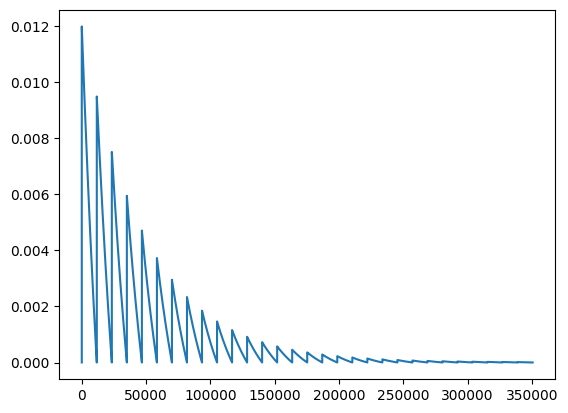

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [67]:
lr_array = []

for epoch in range(30):
    for batch in range(len(train_data_loader)):
        lr_array.append(scheduler.get_last_lr()[0])
        scheduler.step()
        # scheduler.step(epoch + batch / len(train_data_loader))  # For CosineAnnealingWarmRestarts

plt.plot(lr_array)
plt.show()
print(lr_array)


### Memory summary

In [29]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 154962 KiB |  17682 MiB |   9656 TiB |   9656 TiB |
|       from large pool |  84017 KiB |  17615 MiB |   9636 TiB |   9636 TiB |
|       from small pool |  70945 KiB |     87 MiB |     20 TiB |     20 TiB |
|---------------------------------------------------------------------------|
| Active memory         | 154962 KiB |  17682 MiB |   9656 TiB |   9656 TiB |
|       from large pool |  84017 KiB |  17615 MiB |   9636 TiB |